In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from scipy.stats import boxcox
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from xgboost import XGBClassifier
#data_mapping = pd.read_csv("./mapping.csv",na_values=['?','Unknown/Invalid'],low_memory=False)
#admission_type_id_des = data_mapping.iloc[0:8].reset_index(drop= True)
#discharge_type_id_des = data_mapping.iloc[9:40].reset_index(drop= True)
#admission_source_id_des = data_mapping.iloc[41:].reset_index(drop= True)

#for i in [discharge_type_id_des,admission_source_id_des] :
#    i.columns = [i.iloc[0][0],'description']
#    i.drop(index=i.index[0],axis=0,inplace=True)
#   i[i.columns[0]] = i[i.columns[0]].astype(int)
#   i = i.set_index(i.columns[0])
    
#discharge_type_id_des = discharge_type_id_des.set_index(discharge_type_id_des.columns[0]).sort_index()
#admission_source_id_des = admission_source_id_des.set_index(admission_source_id_des.columns[0]).sort_index()

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV



The objective of our analysis is to determine whether a patient will be readmitted to the hospital within a 30-day timeframe. The variable of interest encompasses three categories, namely, readmission within less than 30 days, readmission after more than 30 days, and no readmission. To facilitate binary classification, we have combined the categories of no readmission and readmission after more than 30 days into a single category, labeled as "0." The category of readmission within less than 30 days has been labeled as "1."

# Exploratory data Analysis and preprocessing



## Data visualization and manipulation

### Dealing with Missing Values


In [2]:
raw_data = pd.read_csv("./data.csv",na_values=['?','Unknown/Invalid'],low_memory=False)

def missing_data_info(df):
    # some stats about the missing values in the data 
    null_counts = df.isnull().sum()
    null_cols = null_counts[null_counts > 0].index.tolist()

    print("*************************Missing Data info***************************************")
    print("Length of All data : ",len(df ))
    print("Length of data with non nulls : ",len(df.dropna()))
    print("Number of columns with at least one null value:",len(null_cols))
    if len(null_cols) > 0:
        print("Column names and their number of missing values:")
        adf = df[null_cols]
        adf_null_counts = adf.isnull().sum()
        print(adf_null_counts)
    print("****************************************************************")
    
missing_data_info(raw_data)


*************************Missing Data info***************************************
Length of All data :  101766
Length of data with non nulls :  1043
Number of columns with at least one null value: 8
Column names and their number of missing values:
race                  2273
gender                   3
weight               98569
payer_code           40256
medical_specialty    49949
diag_1                  21
diag_2                 358
diag_3                1423
dtype: int64
****************************************************************


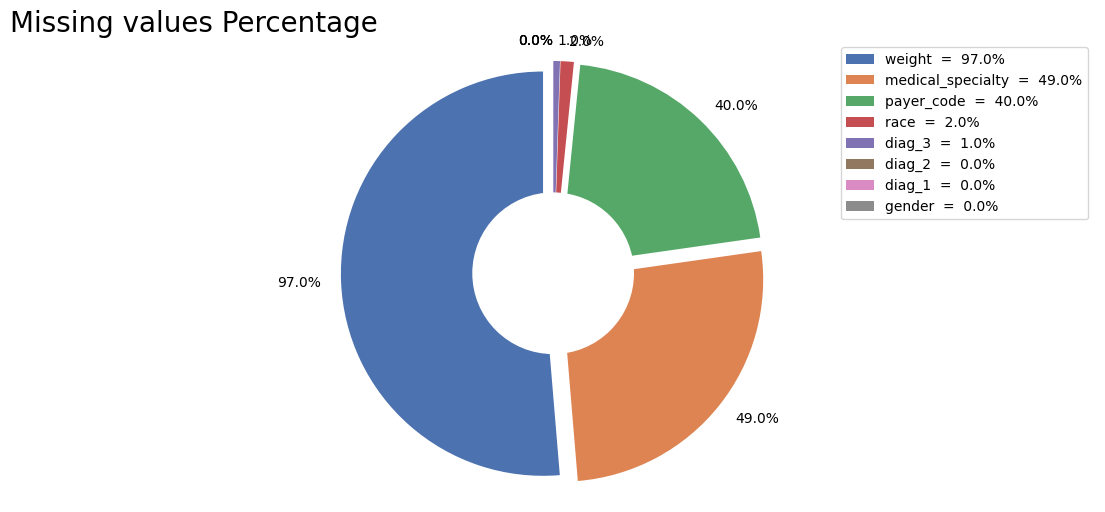

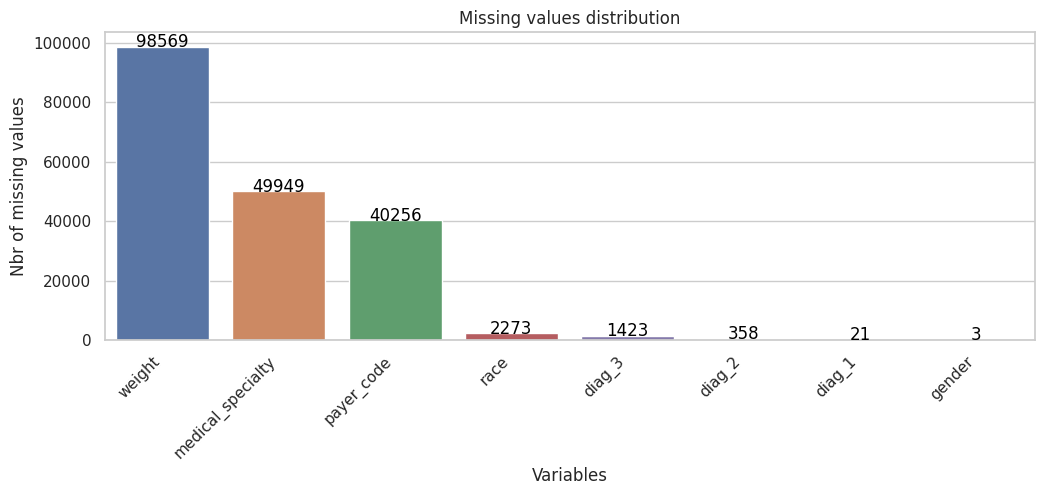

,Variables,total_missing_values,missing_values_rate(%),Nbr_of_unique_values
0,weight,98569,97.0,10
1,medical_specialty,49949,49.0,73
2,payer_code,40256,40.0,18
3,race,2273,2.0,6
4,diag_3,1423,1.0,790
5,diag_2,358,0.0,749
6,diag_1,21,0.0,717
7,gender,3,0.0,3


In [3]:

def bar_chart_plotter(df,x,y,title):
    # Set the style and palette
    sns.set(style="whitegrid")
    colors = sns.color_palette("deep")
    # Create the bar chart
    fig, ax = plt.subplots(figsize=(12, 4))
    sns.barplot(x=df[x], y=df[y], data=df, palette=colors)
    # Set the title and labels
    ax.set_title(title)
    ax.set_xlabel("Variables")
    ax.set_ylabel("Nbr of missing values")
    # Customize the x-axis labels
    plt.xticks(rotation=45, ha="right")
    # Add the values as labels above each bar
    for index, row in df.iterrows():
        ax.text(index, row[y] + 5, str(row[y]), color='black', ha="center")
    # Show the chart
    plt.show()

def pie_chart_plotter(df,x,y, title, labels = None,legend = None):  
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    num_colors = len(df[y])
    color_palette = sns.color_palette("deep", num_colors)
    colors = color_palette.as_hex()
    
    explode = [0.05]*len(df[y])
   
    ax.pie(df[y], colors=colors ,labels = labels,startangle=90, explode=explode, 
                                  labeldistance=1.1, radius=1)
   
    ax.set_title(title, fontsize=20, loc= 'left')
    
    ax.legend(legend, loc="best")
    # set text properties of labels
    #plt.setp(labels, fontsize=12, fontweight='bold', color='black', bbox=dict(facecolor='white', edgecolor='black'))
   
    # create a circle at the center of the pie
    centre_circle = plt.Circle((0,0),0.40,fc='white')
    fig.gca().add_artist(centre_circle)
    # set equal aspect ratio
    ax.axis('equal')
    # show the plot
    plt.show()



def visualize_missing_data(df):
    data_length = len(df)
    null_counts = df.isnull().sum()
    null_cols =null_counts[null_counts > 0]

    null_stats_df = pd.DataFrame(null_cols, columns=["total_missing_values"])
    null_stats_df[' missing_values_rate(%)'] = ((null_stats_df['total_missing_values'] / data_length ) * 100).round()

    nbr_uniquevals = [len(df[col].unique()) for col in null_cols.index.tolist()]
    uniquevals = [df[col].unique() for col in null_cols.index.tolist()]
    null_stats_df['Nbr_of_unique_values'] = nbr_uniquevals
   
    #pie chart

    null_stats_df = null_stats_df.sort_values(by='total_missing_values', ascending = False)

    null_stats_df.index.name = 'Variables'
    percents = null_stats_df[null_stats_df.columns[1]].astype(str) + '%'
    legend = null_stats_df.index + '  =  '+ percents 

    pie_chart_plotter(null_stats_df,null_stats_df.index,null_stats_df.columns[1],'Missing values Percentage',percents,legend)
   
    #bar chart 
    null_stats_df.reset_index(inplace=True)
    bar_chart_plotter(null_stats_df,null_stats_df.columns[0],null_stats_df.columns[1],'Missing values distribution')
    
    return null_stats_df

visualize_missing_data(raw_data)

- Variables race,gender,diag_1,diag_2,diag_3 have fairly low missing values compaired to others,so we decided to impute the missing values with the most common value.
- Variables gender, payer_code and medical_specialty have respectively 97%,40%,49% missing values so there is no usefulness in filling them, we decided to drop them.
 

In [4]:
# Impute columns with fairly low number of missing values with most common value 
columns_to_impute = ['race', 'gender','diag_1','diag_2','diag_3']
for col in columns_to_impute : 
    most_comon_value = raw_data[col].mode()[0]
    raw_data[col] = raw_data[col].fillna(most_comon_value)

# drop gender, payer_code and medical_specialty
raw_data = raw_data.drop(['weight','payer_code','medical_specialty'], axis = 1) 


### Target Variable distribution

In [5]:
raw_data.readmitted = [1 if val =='<30' else 0 for val in raw_data.readmitted]

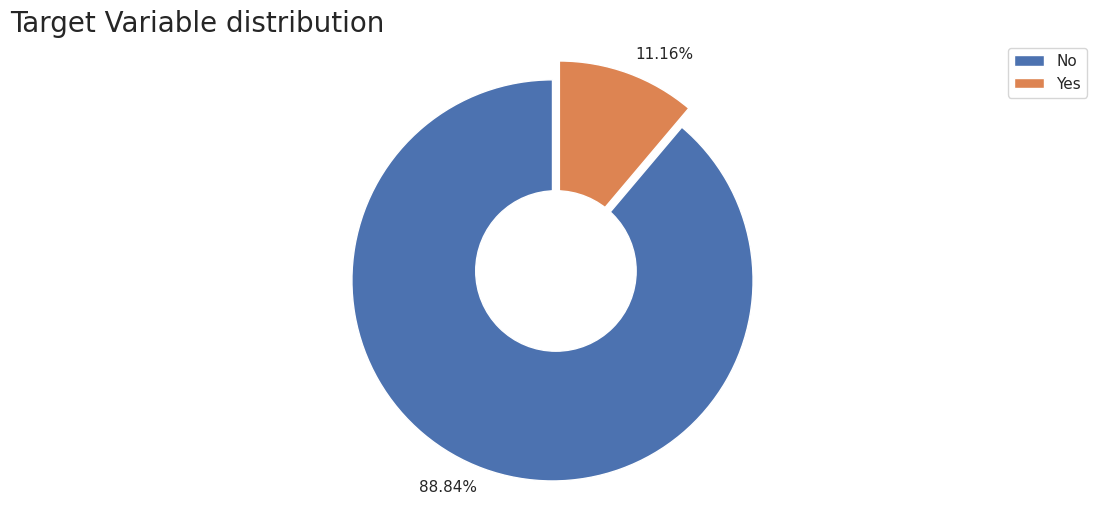

In [6]:
values = raw_data.readmitted.value_counts().tolist()
legend = ['No','Yes']
labels = [ str(round((value / len(raw_data) * 100),2))+'%' for value in values] 
df = pd.DataFrame({'Values' :values, 'labels' :labels })
pie_chart_plotter(df ,'labels', 'Values','Target Variable distribution',labels,legend)


### Feature preparation

#### Utility functions

In [7]:
def plot_feature_distribution(df,feature):
    sns.set(style='whitegrid', rc={'axes.facecolor': '#ffffff','figure.facecolor': '#fdf8f7','axes.grid': False})
    
    plt.figure(figsize=(10,6))
    feature_counts = df[feature].value_counts()
   
    ax = sns.countplot(x=feature, data=raw_data, palette='pastel', order = feature_counts.index )
    plt.xlabel(feature, fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.title('Distribution of '+ feature, fontsize=16)
    
    sns.despine(left=True)
    plt.tick_params(labelsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    
    # add count values for each bar
    for p in ax.patches:
        ax.annotate(format(p.get_height(), '.0f'),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha = 'center', va = 'center', xytext = (0, 10),
                    textcoords = 'offset points', fontsize=12)
    plt.show()


def plot_prob_density(df,col):
    fig = plt.figure(figsize=(10,5))

    #readmitted = 0
    ax = sns.kdeplot(df.loc[(df.readmitted == 0), col],
                    color = "r", shade = True,label = "Not Readmitted")
    #readmitted = 1
    ax = sns.kdeplot(df.loc[(df.readmitted == 1), col],
                    color = "g", shade = True, label = "Readmitted")
    
    ax.legend(loc="upper right")

    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    ax.set_title(col+" -  Readmission")
    plt.show()

#### Race

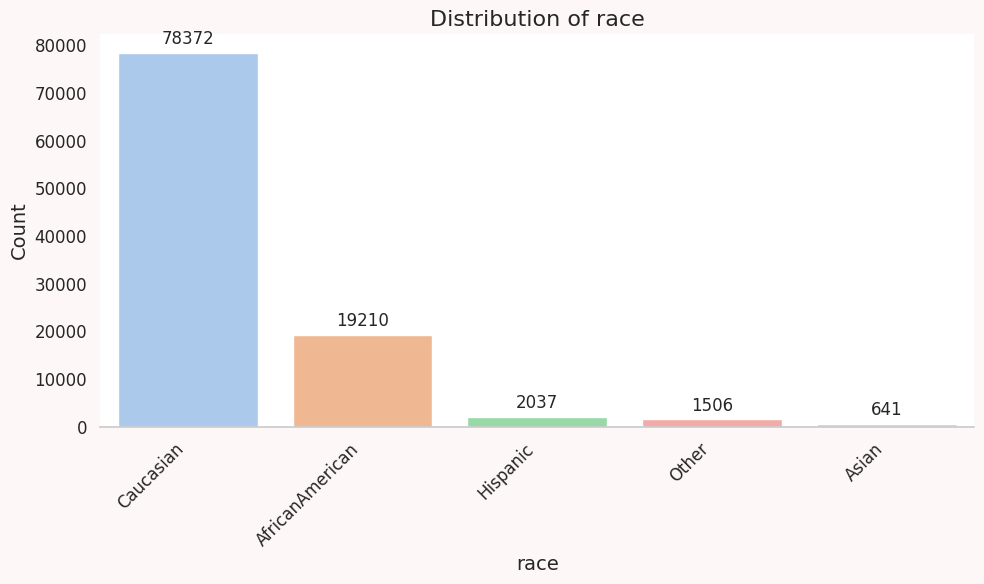

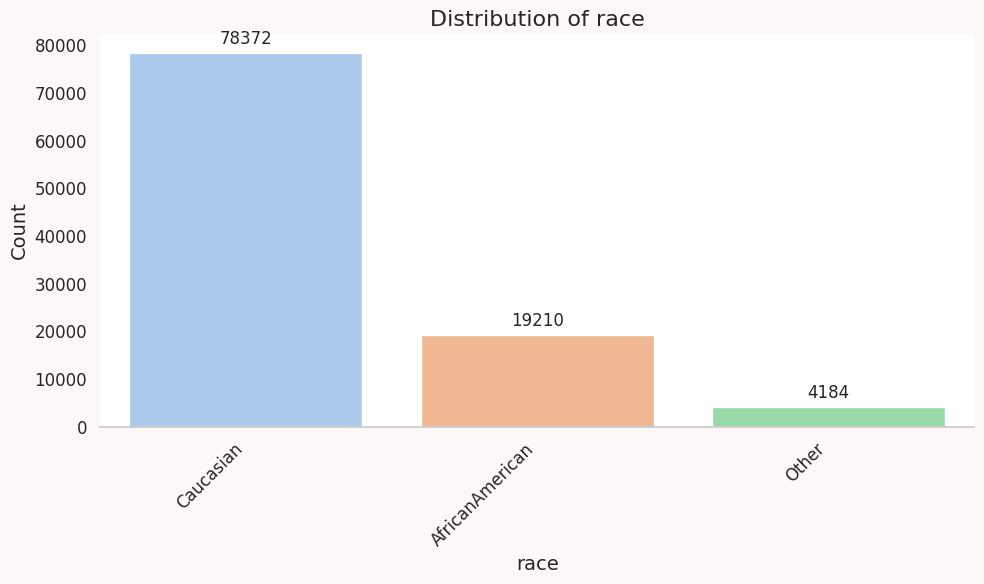

In [8]:
plot_feature_distribution(raw_data,'race')
mapping = {"Asian":"Other","Hispanic":"Other"}
raw_data.race = raw_data.race.replace(mapping)
plot_feature_distribution(raw_data,'race')

#### Age

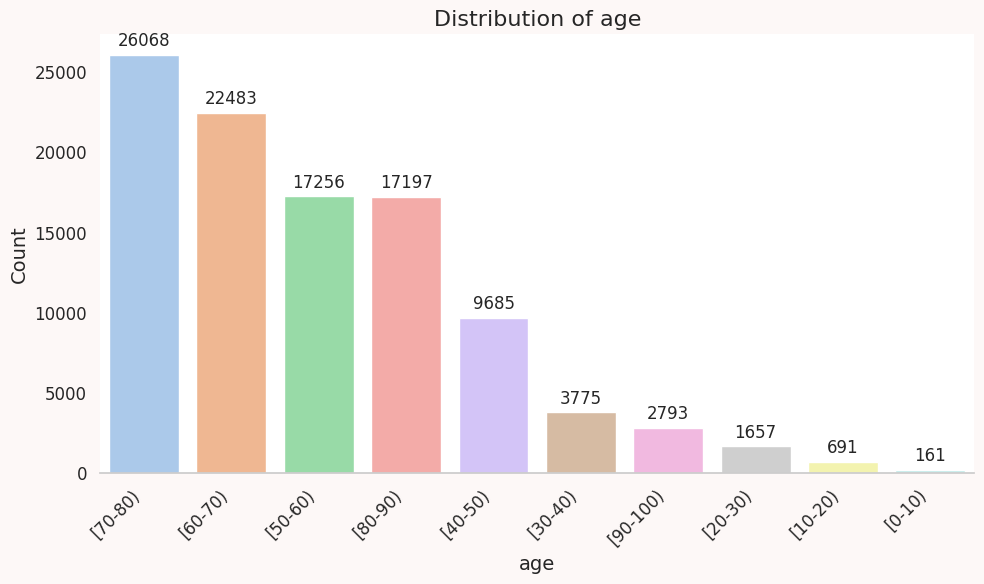

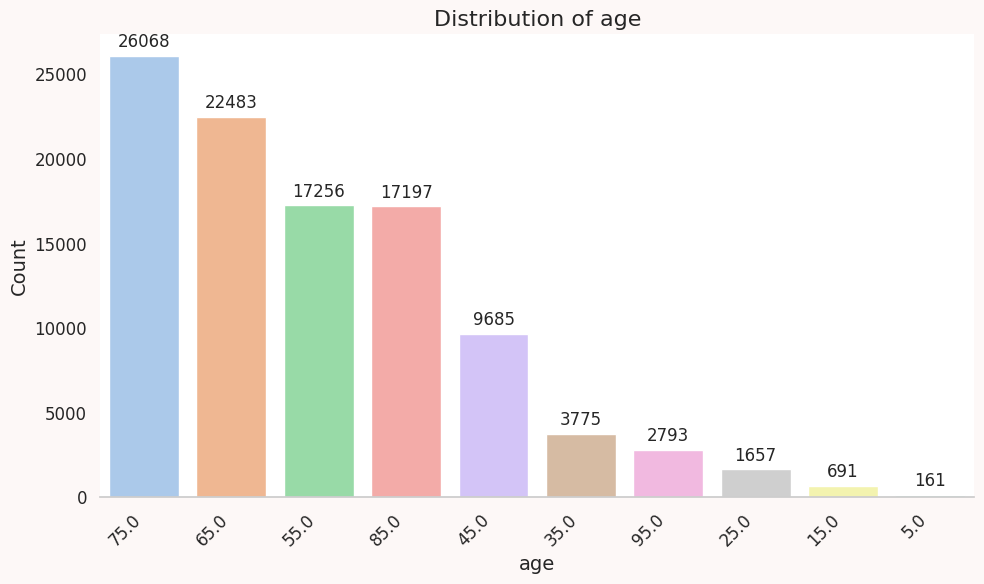

mean age :  65.96702238468644


In [9]:

plot_feature_distribution(raw_data,'age')
raw_data['age'].head(5)
raw_data['age'] = raw_data['age'].apply(lambda x : ( int(x.split('-')[0].strip('[')) +  int(x.split('-')[1].strip(')')) ) / 2 ) 
raw_data['age'].head(5)
plot_feature_distribution(raw_data,'age')

print('mean age : ', raw_data['age'].mean())

#### Gender

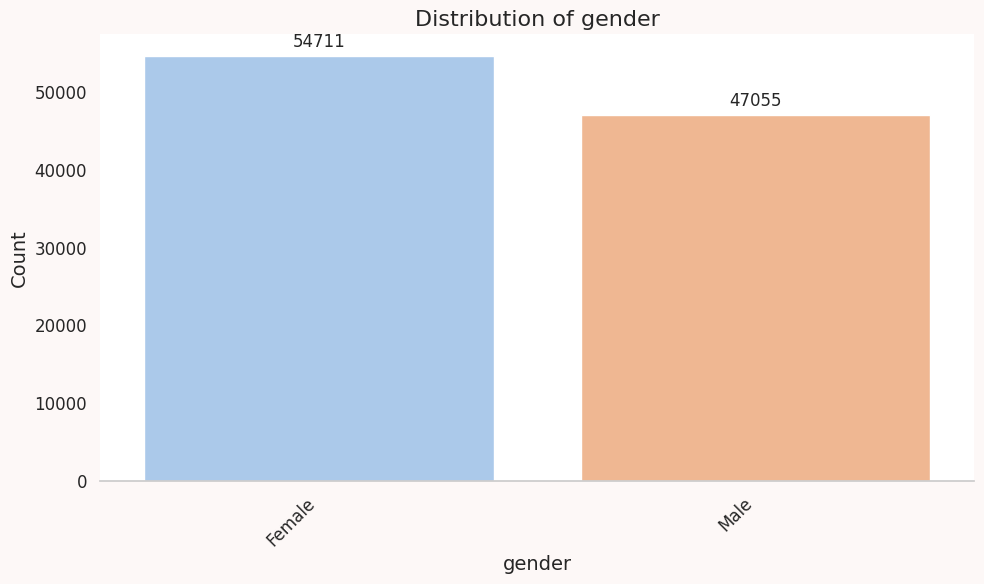

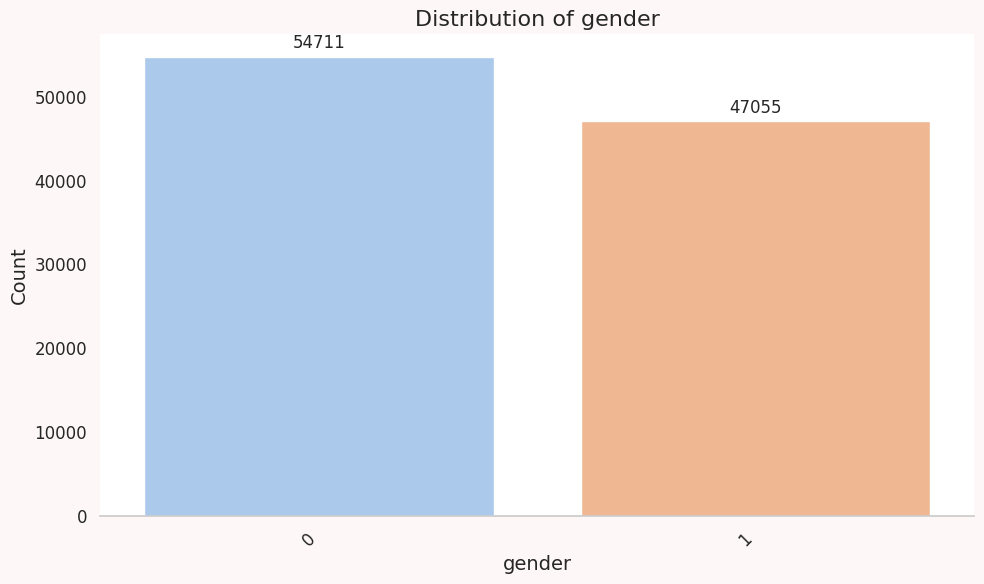

In [10]:
plot_feature_distribution(raw_data,'gender')
mapping = {"Female":0,"Male":1}
raw_data.gender = raw_data.gender.replace(mapping)
plot_feature_distribution(raw_data,'gender')

#### Admission type ID 

- Emergency : 1
- Urgent : 2
- Elective : 3
- Newborn : 4
- Not Available : 5
- NULL : 6
- Trauma Center : 7
- Not Mapped : 8

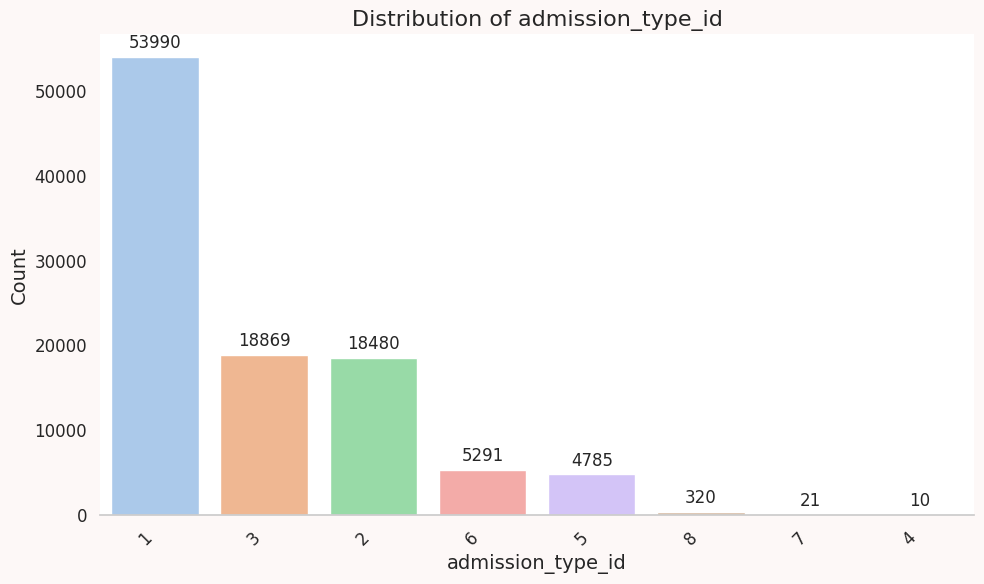

In [11]:
plot_feature_distribution(raw_data,'admission_type_id')

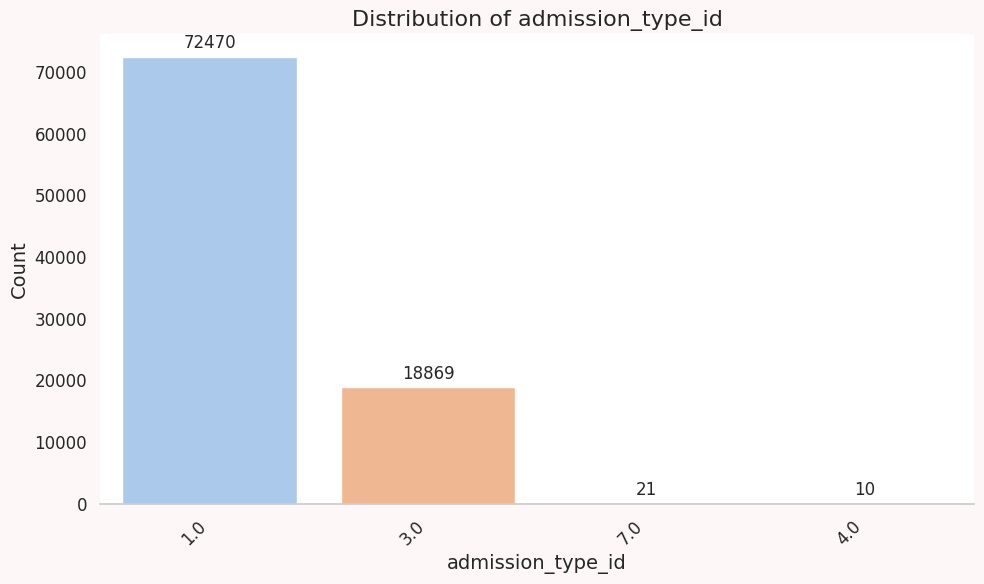

In [12]:

mapping = {2:1, 5:np.nan,6:np.nan,8:np.nan}
raw_data['admission_type_id'] = raw_data['admission_type_id'].replace(mapping)
plot_feature_distribution(raw_data,'admission_type_id')

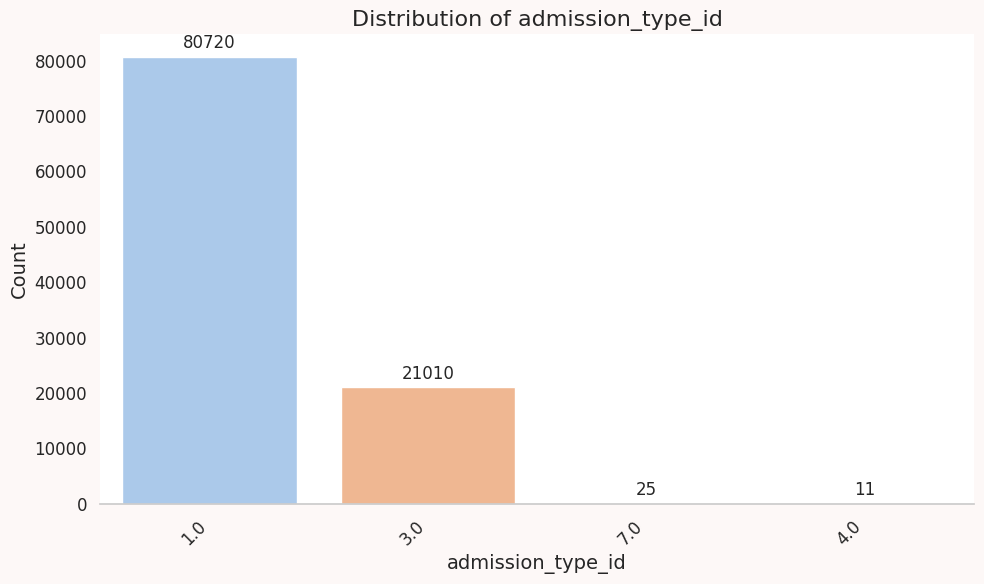

In [13]:

def fillna_distribution(df,col):
    #fill missing values acording to distribution of non_missing values 
    value_counts = df[col].value_counts(normalize=True)
    missing_mask = df[col].isnull()
    missing_count = missing_mask.sum()
    fill_values = np.random.choice(value_counts.index, size=missing_count, p=value_counts.values)
    df.loc[missing_mask, col] = fill_values
    df[col].value_counts(normalize=True)

fillna_distribution(raw_data,'admission_type_id')
plot_feature_distribution(raw_data,'admission_type_id')


#### Discharge Disposition ID

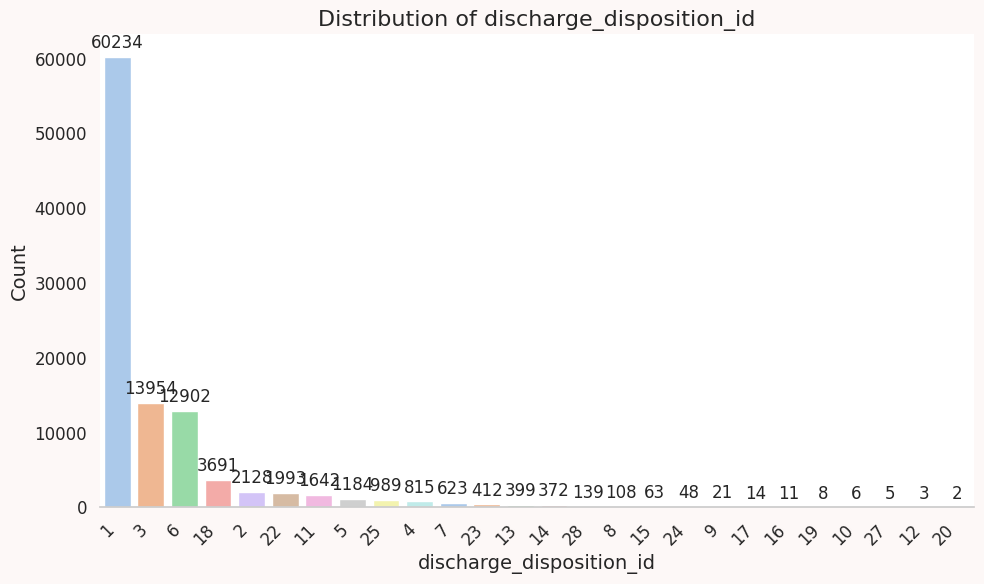

In [14]:
plot_feature_distribution(raw_data,'discharge_disposition_id')

Number of catergories:  26
Number of missing values:  14194


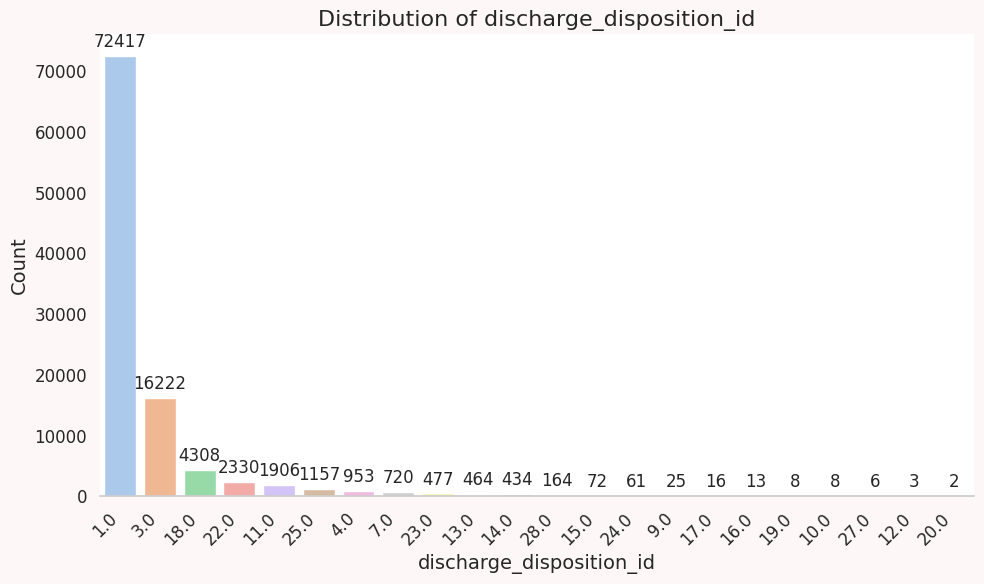

In [15]:
# fill nulls according to distribution of values
print('Number of catergories: ',len(raw_data['discharge_disposition_id'].unique()) )

mapping_nulls = {'Expired':np.nan,'Not Mapped':np.nan,'Unknown/Invalid':np.nan,'NULL':np.nan }
raw_data['discharge_disposition_id'] = raw_data['discharge_disposition_id'].replace(mapping)

print('Number of missing values: ',raw_data['discharge_disposition_id'].isnull().sum())
fillna_distribution(raw_data,'discharge_disposition_id')
plot_feature_distribution(raw_data,'discharge_disposition_id')


In [16]:
len(raw_data['discharge_disposition_id'].unique())
print('Number of catergories After filling null values: ',len(raw_data['discharge_disposition_id'].unique()) )


Number of catergories After filling null values:  22


#### Admission Source ID

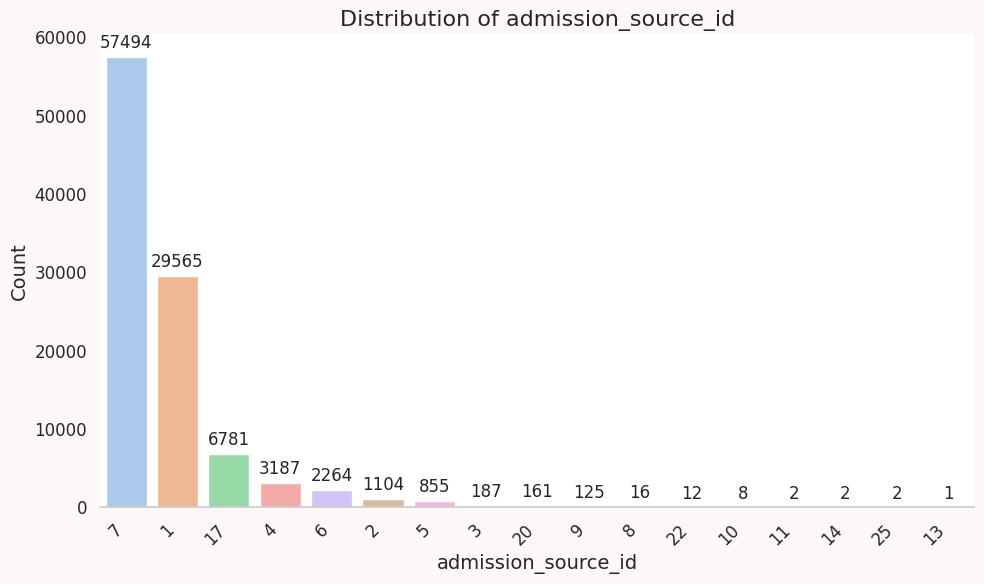

In [17]:
plot_feature_distribution(raw_data,'admission_source_id')

Number of missing values:  3135


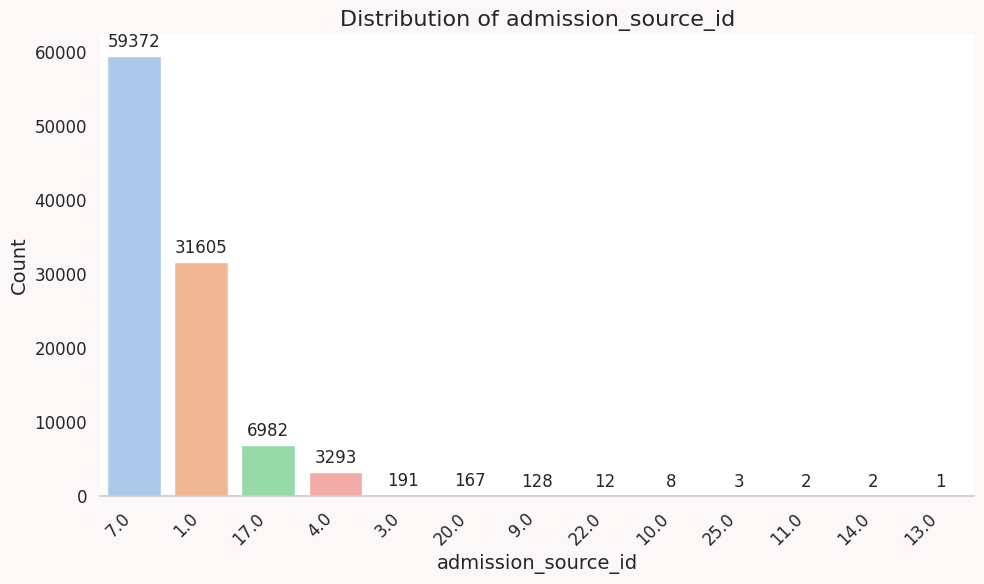

In [18]:
# fill nulls according to distribution of values
mapping_nulls = {'Expired':np.nan,'Not Mapped':np.nan,'Unknown/Invalid':np.nan,'NULL':np.nan ,'Not available':np.nan}
raw_data['admission_source_id'] = raw_data['admission_source_id'].replace(mapping)
print('Number of missing values: ',raw_data['admission_source_id'].isnull().sum())
fillna_distribution(raw_data,'admission_source_id')
plot_feature_distribution(raw_data,'admission_source_id')

#### Time in Hospital

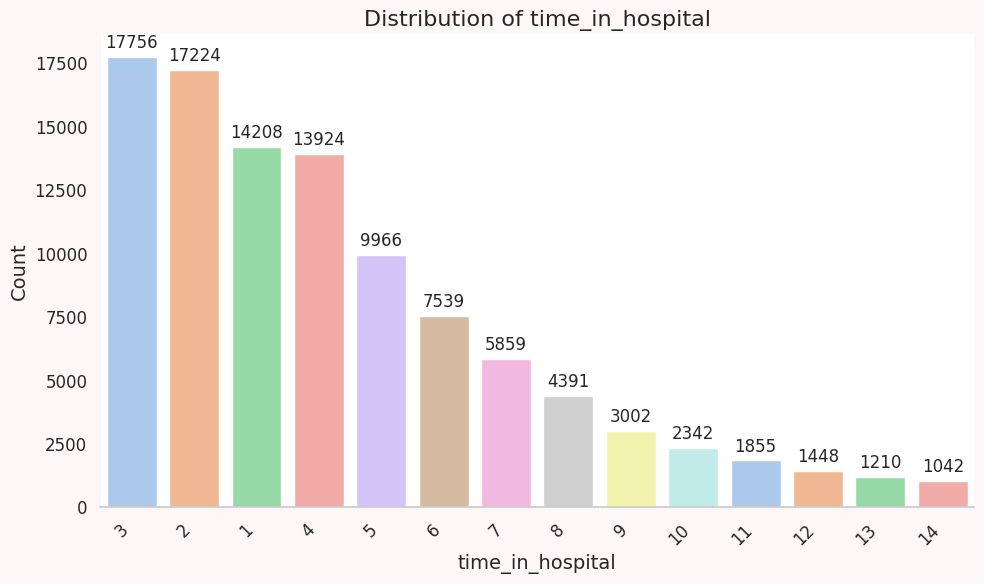

In [19]:
plot_feature_distribution(raw_data,'time_in_hospital')

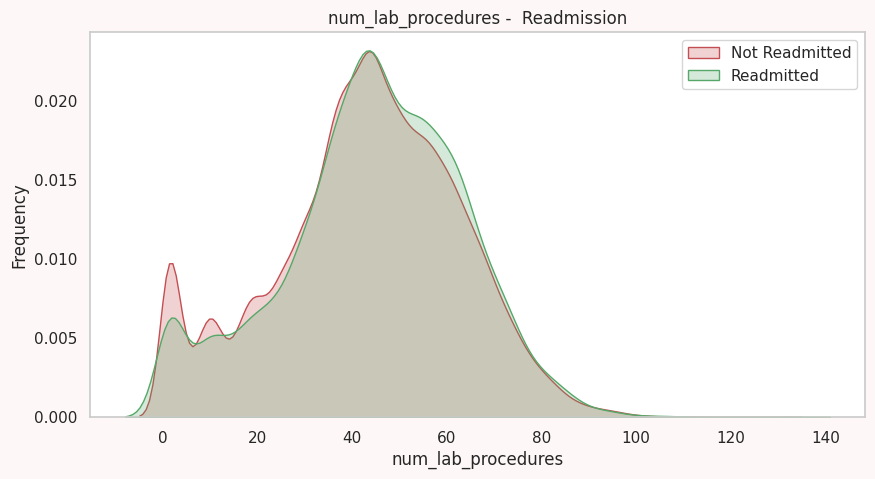

In [20]:
plot_prob_density(raw_data,'num_lab_procedures')

#### Number of Procedures

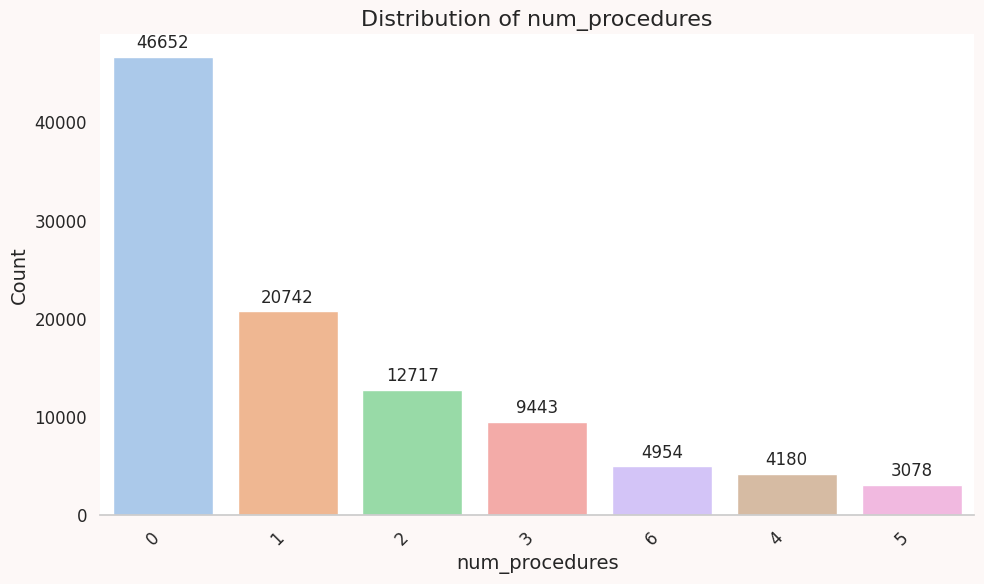

In [21]:
plot_feature_distribution(raw_data,'num_procedures')

#### Number of lab procedures

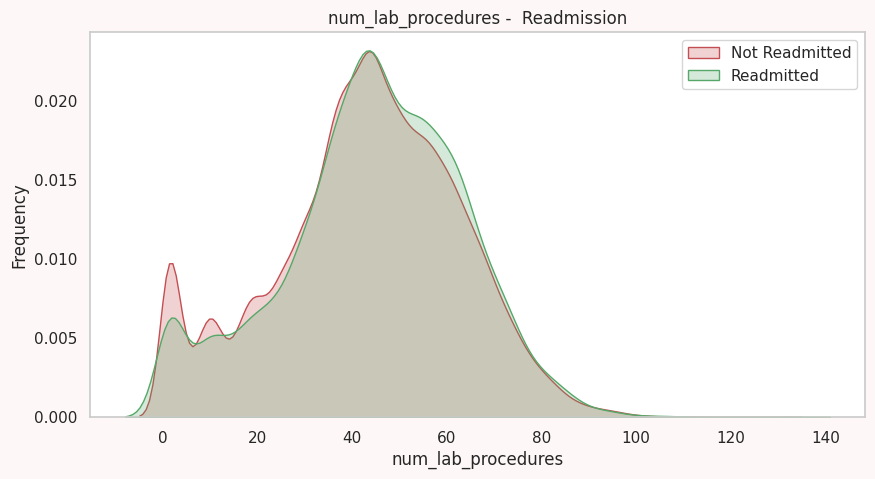

In [22]:
plot_prob_density(raw_data,'num_lab_procedures')

#### Number of Medications

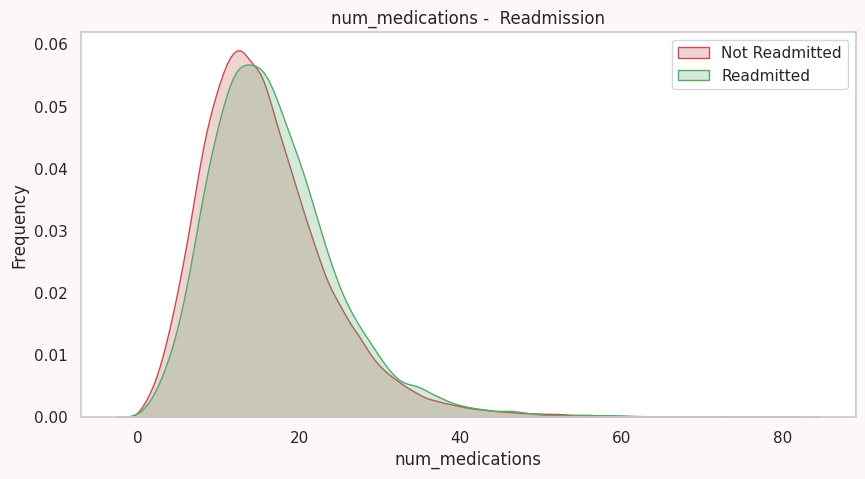

In [23]:
plot_prob_density(raw_data, 'num_medications') 

In [24]:
raw_data['num_medications']

0          1
1         18
2         13
3         16
4          8
          ..
101761    16
101762    18
101763     9
101764    21
101765     3
Name: num_medications, Length: 101766, dtype: int64

#### Diag1, Diag2 and Diag3

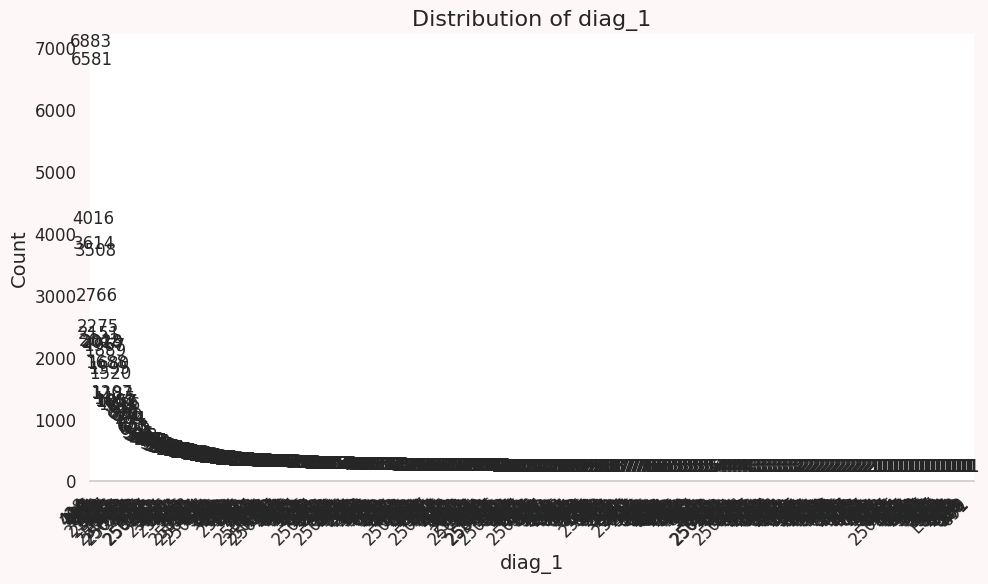

In [25]:
plot_feature_distribution(raw_data,'diag_1')

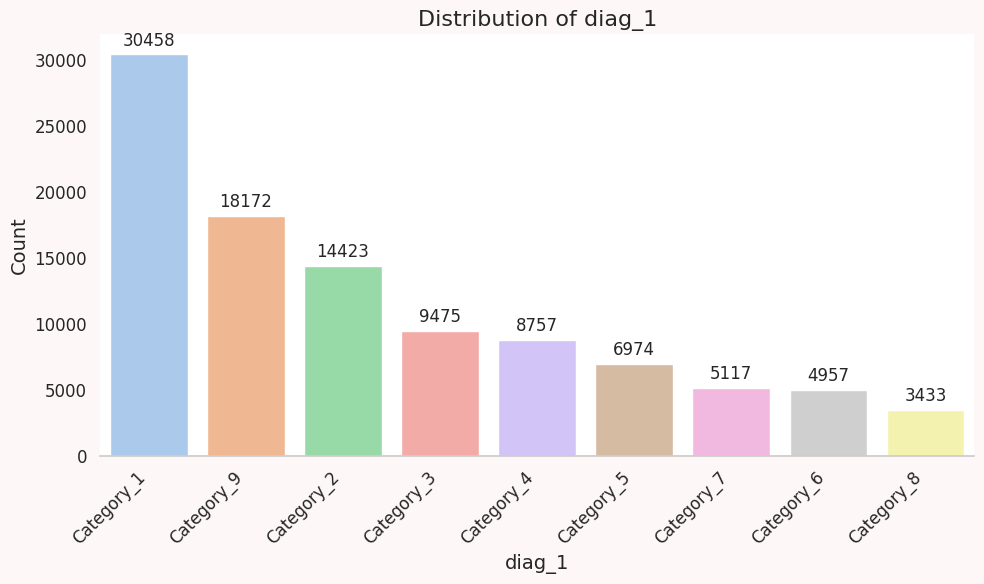

In [26]:
def diagnoses_categorization(col):
    # define the regular expression pattern to match ICD9 codes 
    circulatory = "^3[9-9]\d|4[0-5]\d|785$"
    respiratory = "^46[0-9]|4[7-9][0-9]|5[01][0-9]|786$"
    digestive = "^(52[0-9]|5[3-7][0-9]|787)$"
    Diabetes = "^250\.\d{1,2}|250$"
    Injury = "^(80[0-9]|8[1-9][0-9]|9[0-9]{2})$"
    Musculoskeletal = "^(71[0-9]|7[23][0-9])$"
    Genitourinary = "^(58[0-9]|59[0-9]|6[0-2][0-9]|788)$"
    Neoplasms =  "^(14[0-9]|1[5-9][0-9]|2[0-3][0-9])$"

    other = ["^(79[0-9]|780|781|784|789|783)$",
                "^(24[0-9]|25[1-9]|2[67][0-9])$",
                "^(68[0-9]|69[0-9]|70[0-9]|782)$",
                "^([1-9]|[1-9][0-9]|1[0-3][0-9])$",
                "^(29[0-9]|3[01][0-9])$",
                "^(E|V)\d+",
                "^(28[0-9])$" ,
                "^(32[0-9]|3[3-5][0-9])$",
                "^(63[0-9]|6[4-7][0-9])$",
                "^(36[0-9]|3[78][0-9])$",
                "^(74[0-9]|75[0-9])$",
                "^365\.\d{1,2}$"   
                ]


    cats = [circulatory,respiratory,digestive,Diabetes,Injury,Musculoskeletal,Genitourinary,Neoplasms]

    for cat in cats:  
        raw_data[col] = raw_data[col].str.replace(cat, 'Category_'+str(cats.index(cat)+1), regex=True)

    for o in other:
        raw_data[col] = raw_data[col].str.replace(o, 'Category_'+str(9), regex=True)

diagnoses_categorization('diag_1')
plot_feature_distribution(raw_data,'diag_1')



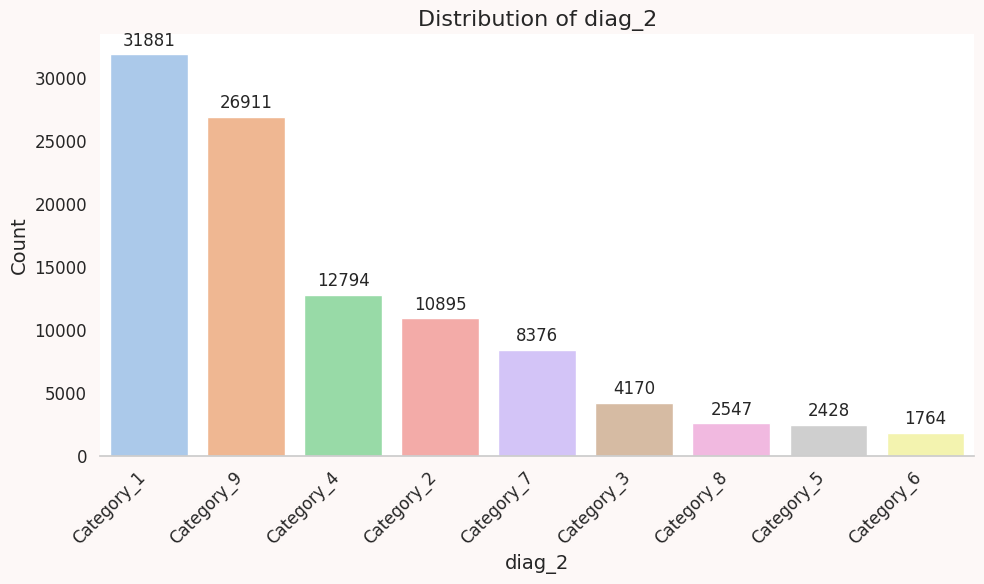

In [27]:
diagnoses_categorization('diag_2')
plot_feature_distribution(raw_data,'diag_2')

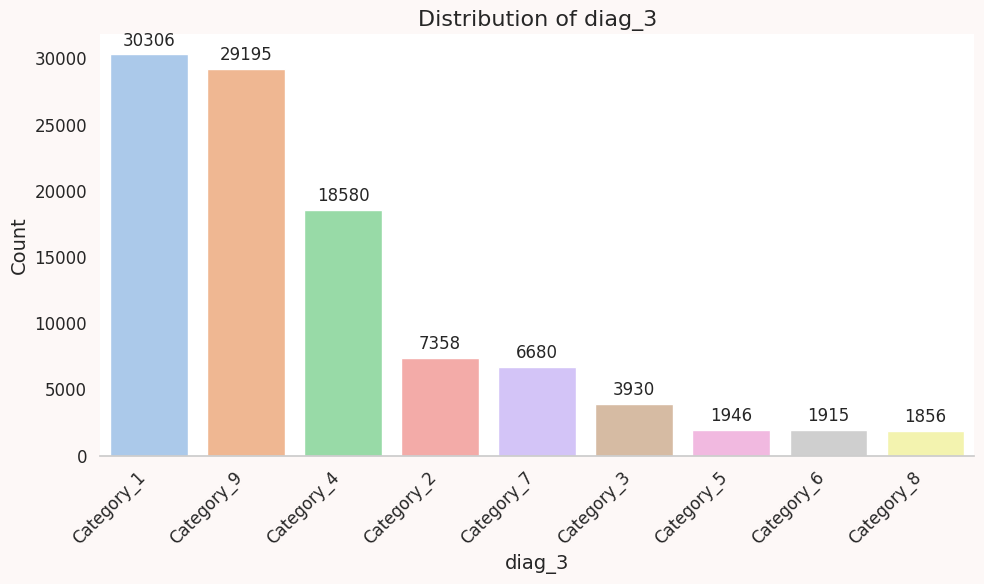

In [28]:
diagnoses_categorization('diag_3')
plot_feature_distribution(raw_data,'diag_3')

#### Change

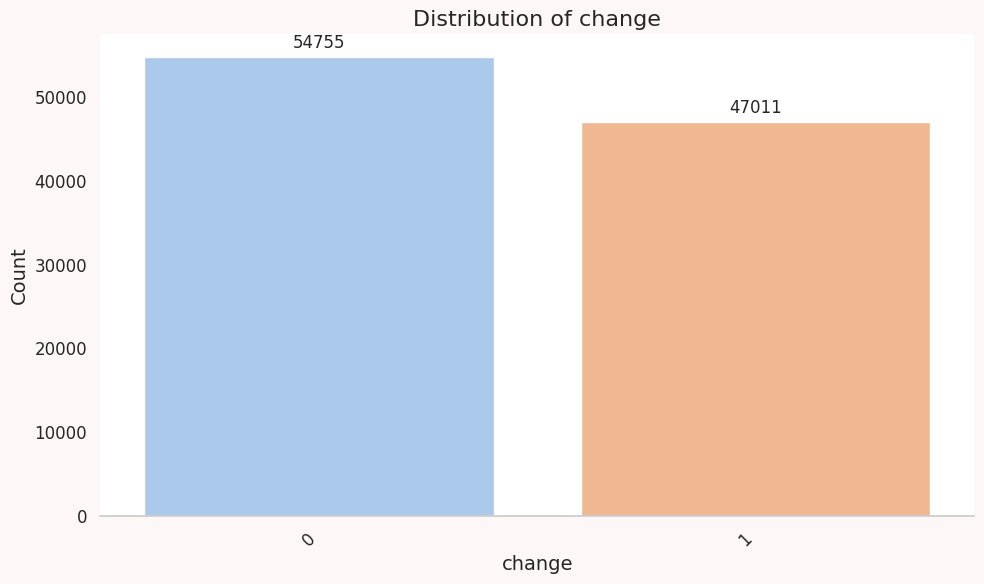

In [29]:
mapping = {'Ch':1,'No':0}
raw_data['change'] = raw_data['change'].replace(mapping)
plot_feature_distribution(raw_data,'change')


#### Glucose Serum Test Result

Indicates the range of the result or if the test was not taken.
Values:

- “>200,”
- “>300,”
- “normal,”
- “none” if not measured

remapped to :

- 1 : abnormal
- 0 : normal
- 2 : not_measured

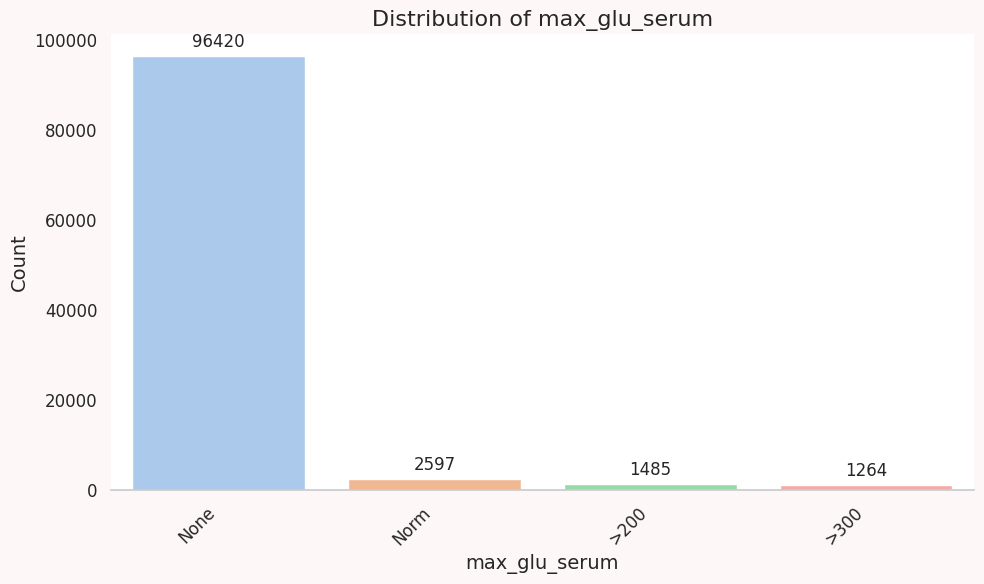

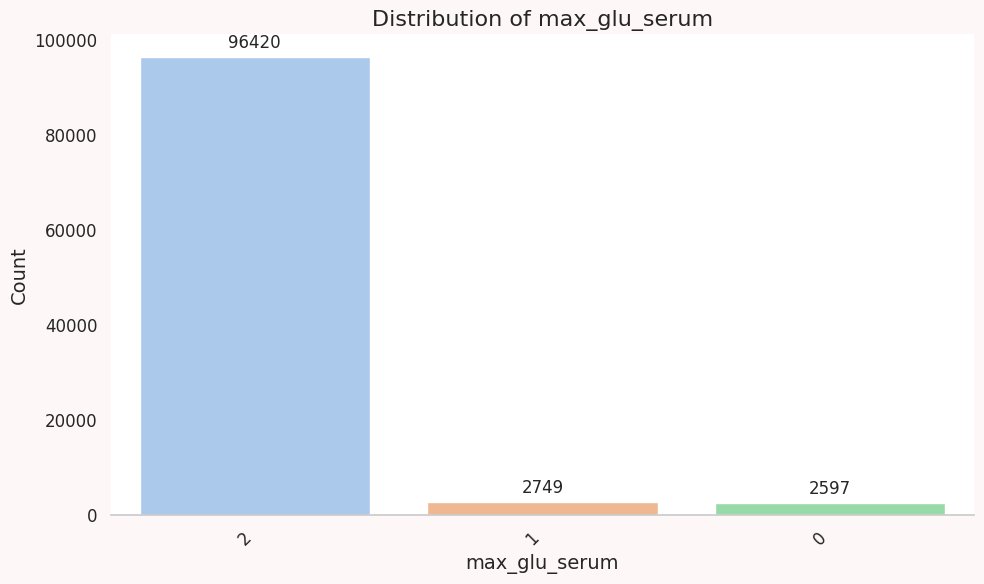

In [30]:


plot_feature_distribution(raw_data,'max_glu_serum')
mapping = {'>200':1,'>300':1,'Norm':0,'None':2}
raw_data.max_glu_serum = raw_data.max_glu_serum.replace(mapping)

plot_feature_distribution(raw_data,'max_glu_serum')


#### A1c test result¶



Indicates the range of the result or if the test was not taken.

- “>8” if the result was greater than 8%,
- “>7” if the result was greater than 7% but less than 8%, “normal”
- if the result was less than 7%, and “none” if not measured.

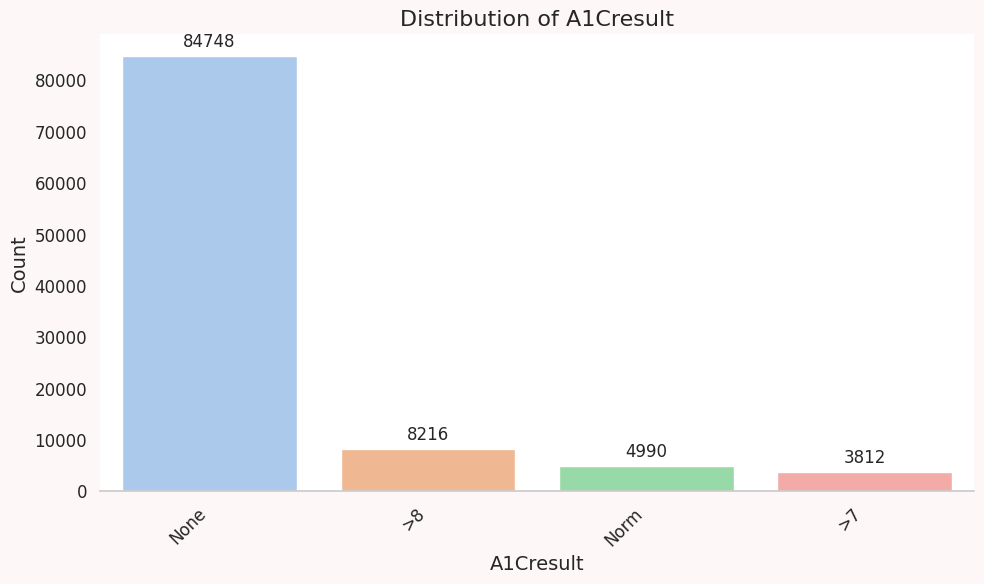

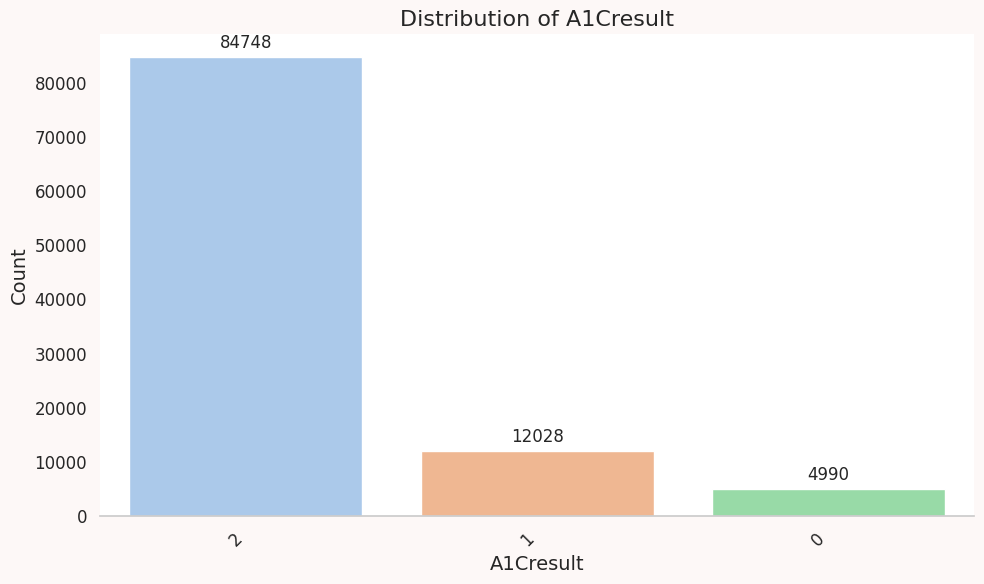

In [31]:
plot_feature_distribution(raw_data,'A1Cresult')
mapping = {'>8':1,'>7':1,'Norm':0,'None':2}
raw_data.A1Cresult = raw_data.A1Cresult.replace(mapping)
plot_feature_distribution(raw_data,'A1Cresult')

#### Diabetes medications¶

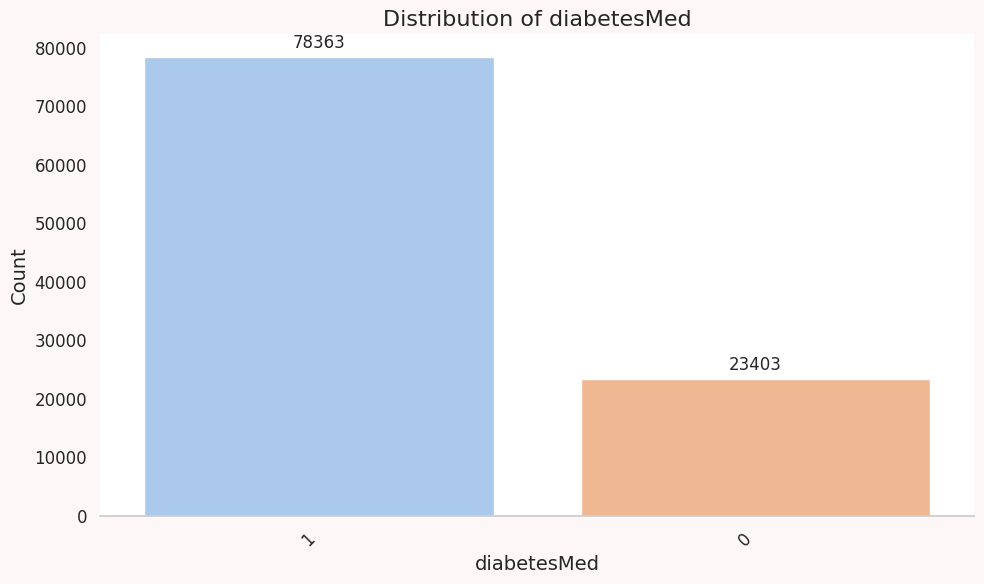

In [32]:
mapping = {'Yes':1,'No':0}
raw_data['diabetesMed'] = raw_data['diabetesMed'].replace(mapping)
plot_feature_distribution(raw_data,'diabetesMed')

#### Number of diagnoses

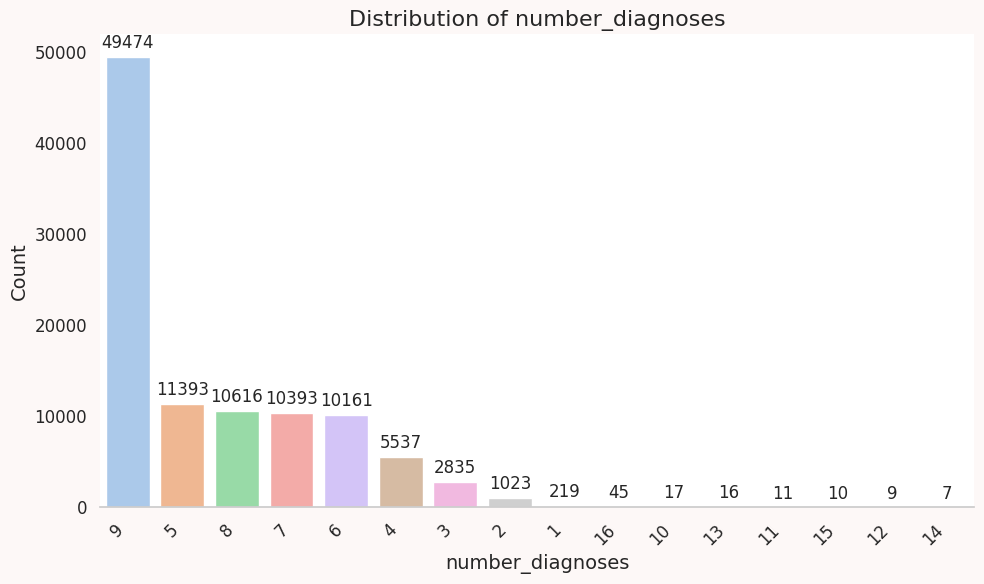

In [33]:
plot_feature_distribution(raw_data,'number_diagnoses')

#### Number of emergency visits 


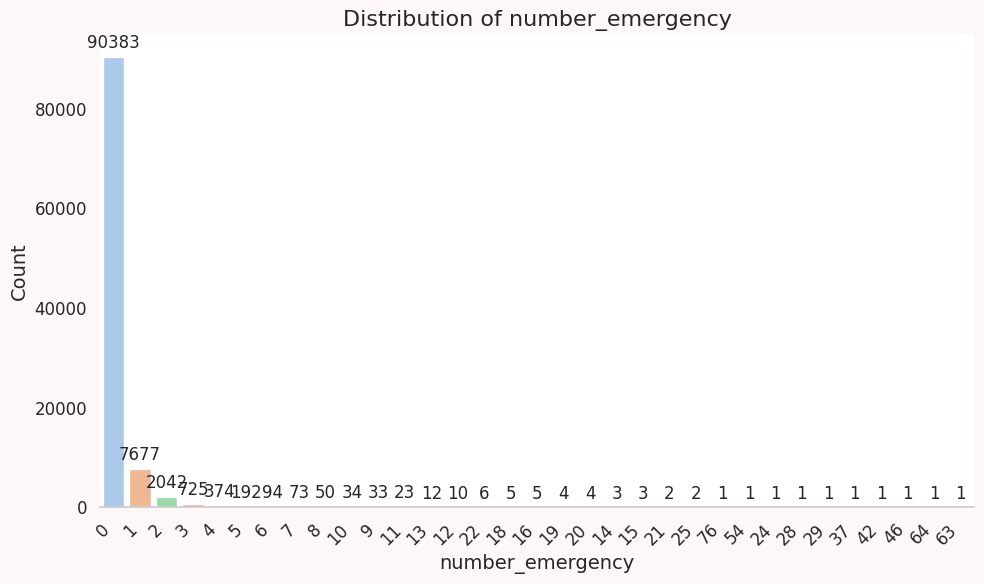

In [34]:
plot_feature_distribution(raw_data,'number_emergency')

####  Hospital visits 

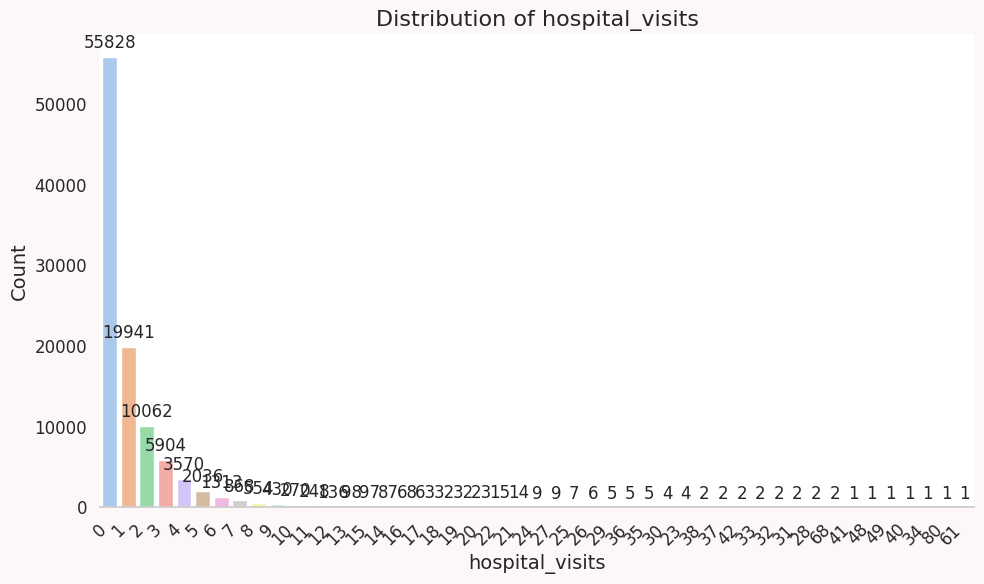

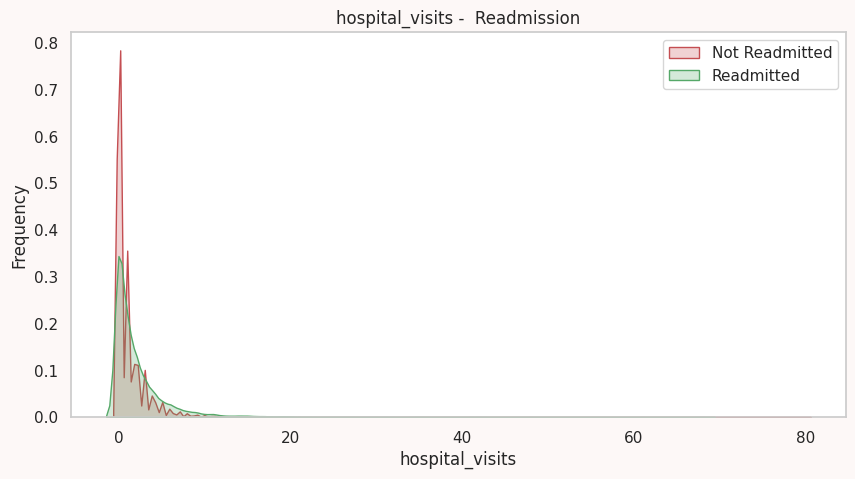

In [35]:
raw_data['hospital_visits'] = raw_data['number_outpatient'] + raw_data['number_emergency'] + raw_data['number_inpatient']

plot_feature_distribution(raw_data,'hospital_visits')
plot_prob_density(raw_data,'hospital_visits')

#### 23 columns for different medications

In [36]:
meds = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide', 'citoglipton',
'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide', 'pioglitazone',
'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'insulin',
'glyburide-metformin', 'glipizide-metformin', 'glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone']


med_values_map = {'No': 0, 'Steady': 0, 'Up': 1, 'Down': -1}

raw_data[meds] = raw_data[meds].replace(med_values_map) 
med_values_diff = raw_data[meds].diff(axis=1)
med_changes = med_values_diff.ne(0).sum(axis=1)
raw_data['num_med_changes'] = med_changes
raw_data['num_med_changes'].value_counts()


1    74063
3    25233
2     1044
5      808
4      511
6       82
7       21
8        4
Name: num_med_changes, dtype: int64

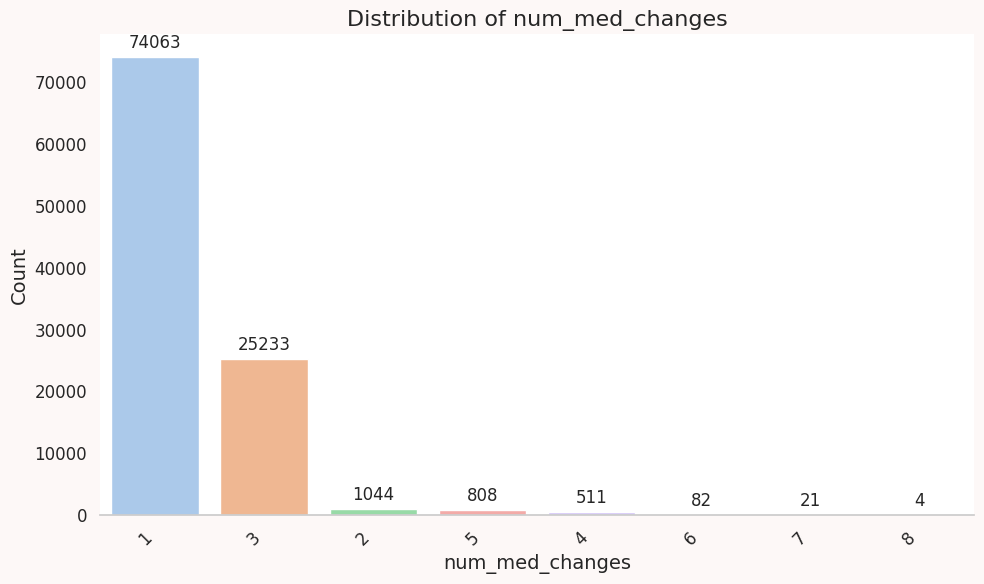

In [37]:
plot_feature_distribution(raw_data,'num_med_changes')
#cop['num_med_changes']


#### Identification columns 

### Influence of the different variables on the Target variable :


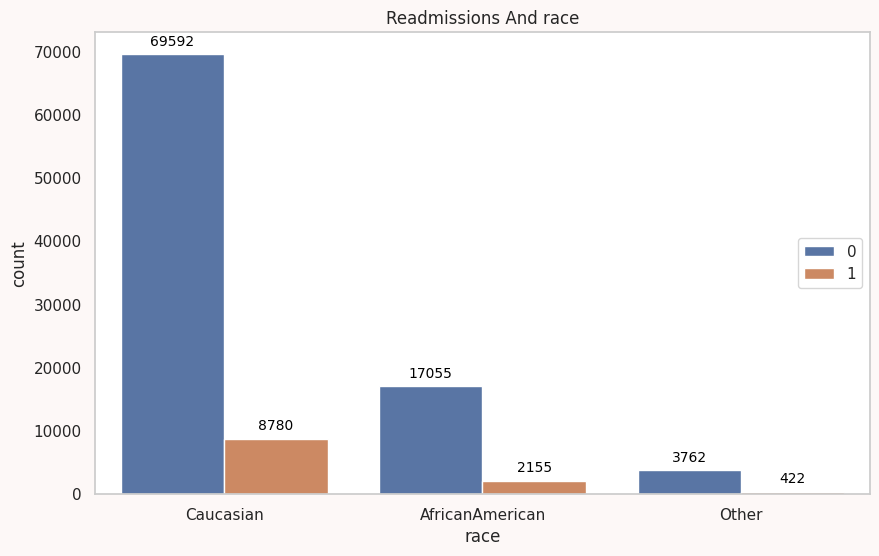

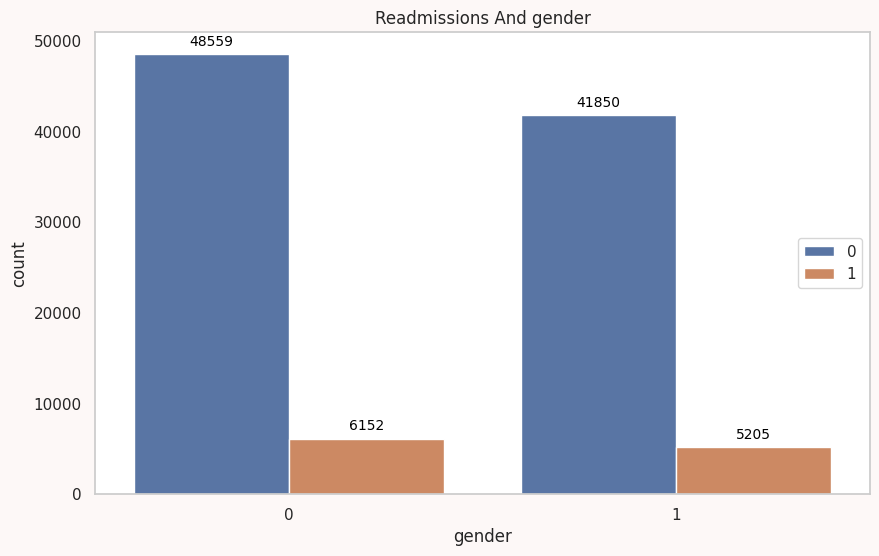

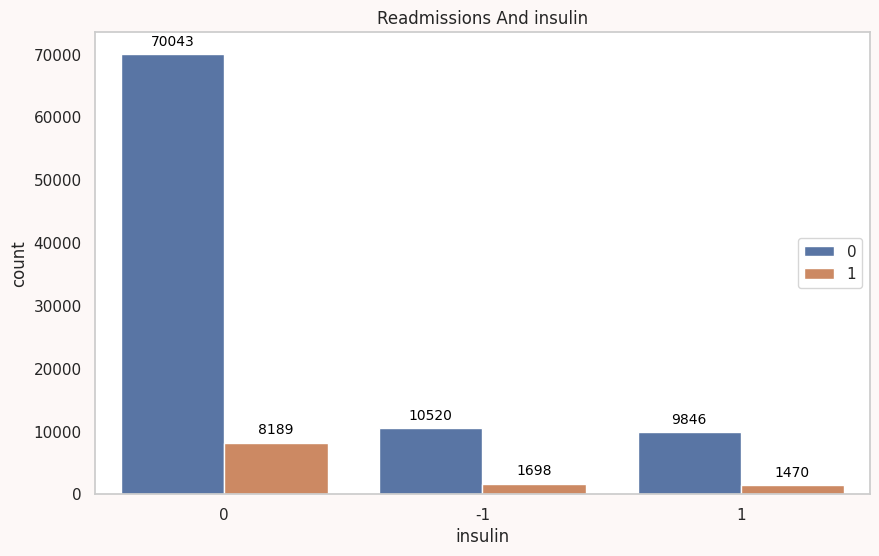

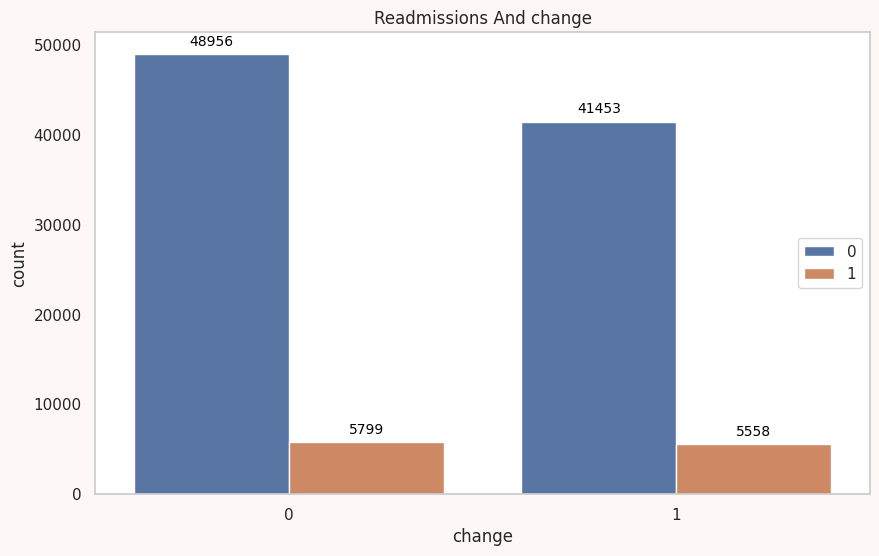

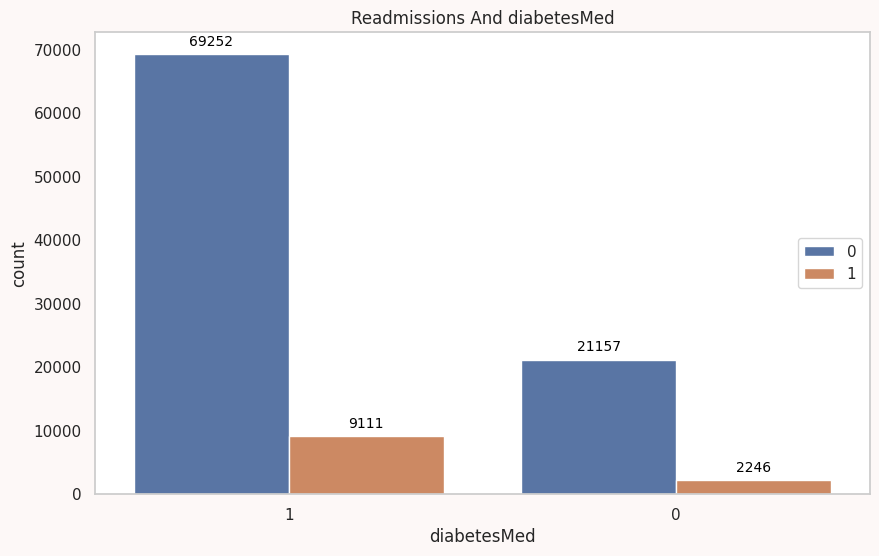

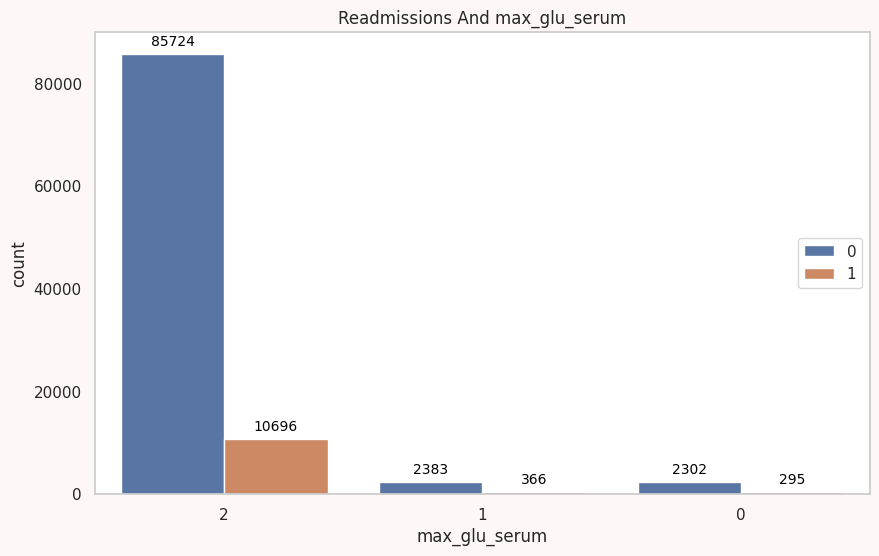

Text(0.5, 1.0, 'Readmission And Number of lab procedures')

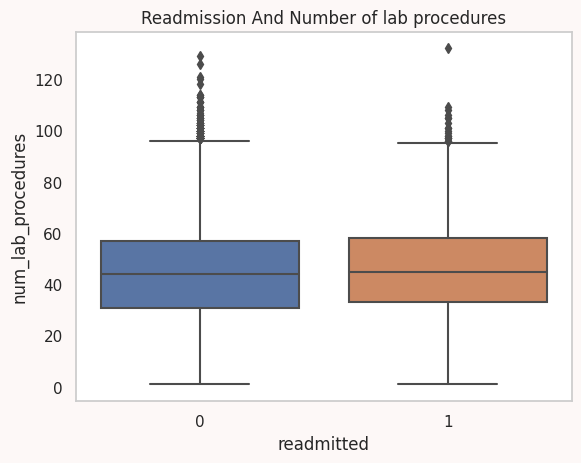

In [38]:
def plot_readmission_correlations(df,col):
    col_readmitted_group = raw_data.groupby([col,'readmitted']).readmitted.count()
    col_data = raw_data[col].unique().tolist()
    readmission = raw_data.readmitted.unique().tolist()
    
    readmitted = []
    for i in col_data:
        for j in readmission:
            if j == 1 :
                readmitted.append(col_readmitted_group[i][j])
            
    order = pd.DataFrame({'col': col_data, 'readmitted':readmitted}).sort_values(by='readmitted',ascending=False).col.tolist()
    
    #plot
    fig, ax =plt.subplots(figsize=(10,6))
    sns.countplot(x=col, hue="readmitted", data=raw_data, palette="deep" ,order = order)
    
    ax.set_title('Readmissions And '+ col)
    ax.legend(loc='right')

    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{height:.0f}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=10, color='black', xytext=(0, 4),
                    textcoords='offset points')
    plt.show()
     
    
plot_readmission_correlations(raw_data,"race")
plot_readmission_correlations(raw_data,"gender")
plot_readmission_correlations(raw_data,"insulin")
plot_readmission_correlations(raw_data,"change")
plot_readmission_correlations(raw_data,"diabetesMed")
plot_readmission_correlations(raw_data,"max_glu_serum")

sns.boxplot(x="readmitted", y="num_lab_procedures", data=raw_data).set_title('Readmission And Number of lab procedures')


# Pre-modelling

### utility functions

In [39]:
def visualize_column_skewness(data,col):
    # Create the histoplot with seaborn
    data = data[col]
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.histplot(data=data, kde=True, color='#ffa600', edgecolor='white', linewidth=1.2, ax=ax)
    # Add vertical lines for median and mean
    median = np.median(data)
    mean = np.mean(data)
    ax.axvline(x=median, linestyle='--', color='#58508d', label='Median', linewidth=1.5)
    ax.axvline(x=mean, linestyle='--', color='#bc5090', label='Mean', linewidth=1.5)

    # Add labels and title
    ax.set_xlabel('Value', fontsize=14)
    ax.set_ylabel('Frequency', fontsize=14)
    ax.set_title('Skewness of variable '+col, fontsize=18)
    # Add legend
    ax.legend(fontsize=14)
    # Remove top and right spines
    sns.despine(top=True, right=True)
    plt.show()


def bar_plot(df,skews,features):
    # Create the bar plot with seaborn
    sns.set_style("whitegrid")
    sns.set_palette("husl")
    
    fig, ax = plt.subplots(figsize=(12, 6))
    sns.barplot(x=skews, y=features, data=df, ax=ax,linewidth = 1)

    # Add labels and title
    ax.set_xlabel(skews, fontsize=14)
    ax.set_ylabel(features, fontsize=14)
    ax.set_title(skews+' distribution', fontsize=18)

    # Add legend
    handles, labels = ax.get_legend_handles_labels()
    #ax.legend(handles, skews, title='Skewness', fontsize=12)
    ax.legend(labels,loc="best")

     # Add bar values
    for rect in ax.patches:
        width = rect.get_width()

        if width > 0: 
            xpos = width-1
        else :
            xpos = width+1

        height = rect.get_y()
        ypos = height + 0.6
        ax.text(width, ypos, f'{width:.2f}', ha='center', va='bottom')
    # Remove top and right spines
    sns.despine(top=True, right=True)

    plt.show()


def visualize_data_skewness(data,numerical_features):
    skew_vals = [ data[i].skew() for i in numerical_features]
    df = pd.DataFrame( {'features': numerical_features, 'Skewness':skew_vals }).sort_values(by='Skewness',ascending = False).reset_index(drop=True) 
    bar_plot(df,'Skewness','features')

def visualize_data_kurtosis(data,numerical_features):
    skew_vals = [ data[i].kurtosis() for i in numerical_features]
    df = pd.DataFrame( {'features': numerical_features, 'Kurtosis':skew_vals }).sort_values(by='Kurtosis',ascending = False).reset_index(drop=True) 
    bar_plot(df,'Kurtosis','features')


def remove_skewness_kurtosis(data, num_cols):
    for col in num_cols:
        if abs(data[col].skew()) > 2:
            data[col] = pd.Series(data[col]+0.001)
            transformed_data = boxcox(data[col],lmbda=0)
            data[col] = transformed_data - 0.001


In [40]:

non_numerical_features = list(raw_data.select_dtypes(exclude=['number']).columns)
admission_discharge_features = ['admission_type_id','discharge_disposition_id','admission_source_id']

identification_features = ['encounter_id','patient_nbr']

#remove binary features, patient identificatation features as well as admission and discharge features
numerical_features = list(raw_data.select_dtypes(include=['number']).columns)
numerical_features = list(filter(lambda x : x not in identification_features and x not in admission_discharge_features, numerical_features))
numerical_features = list(filter(lambda x : len(raw_data[x].unique()) > 3 , numerical_features))



### skewness, kurtosis, feature selection,data augmentation, regularization, ensemble methods 

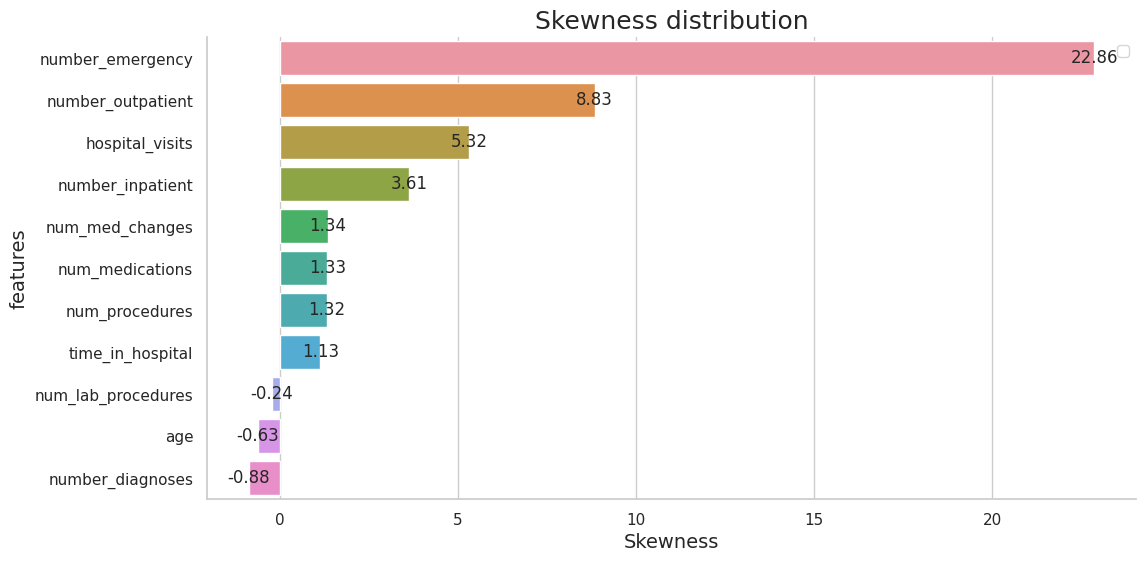

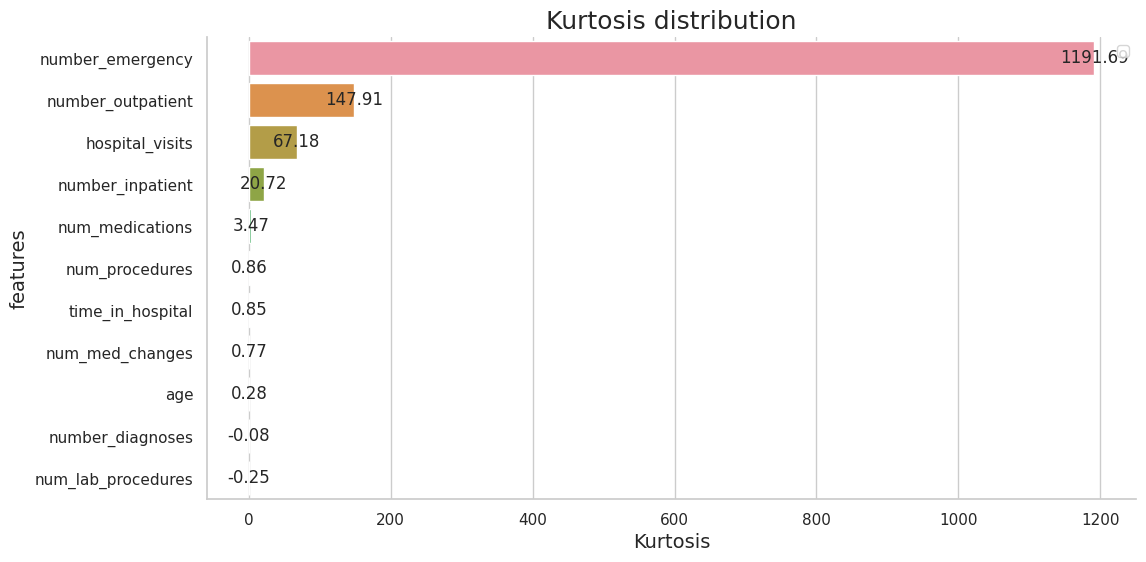

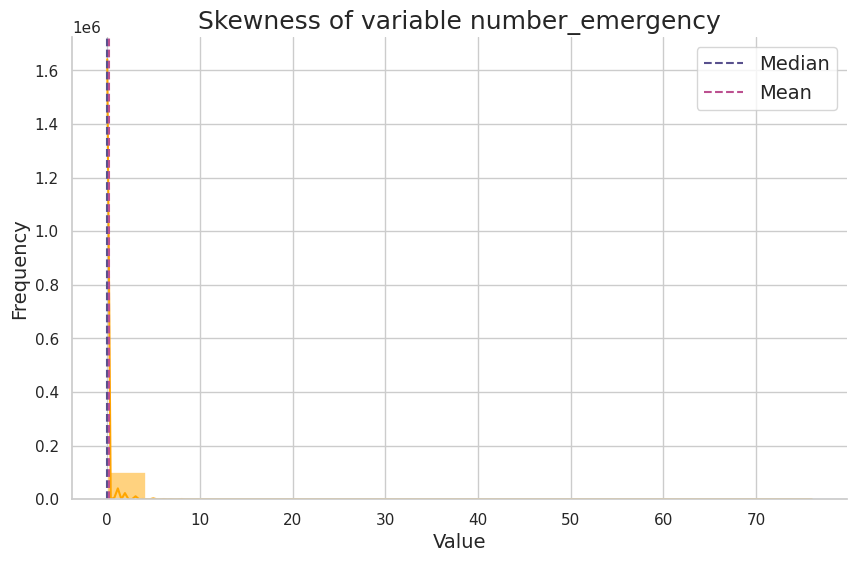

In [41]:
visualize_data_skewness(raw_data,numerical_features)
visualize_data_kurtosis(raw_data,numerical_features)
visualize_column_skewness(raw_data,'number_emergency')

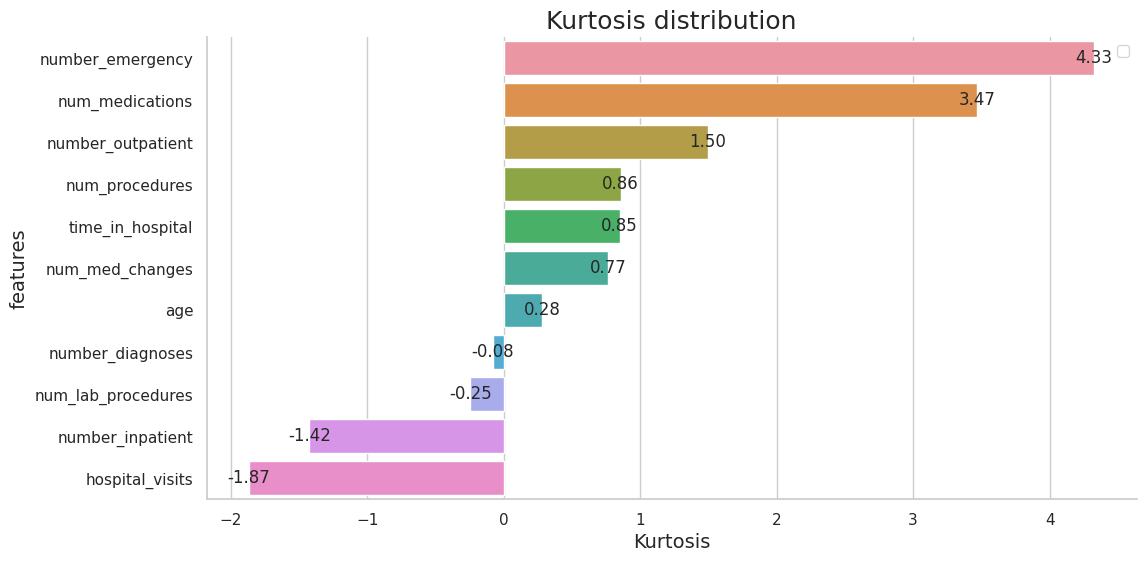

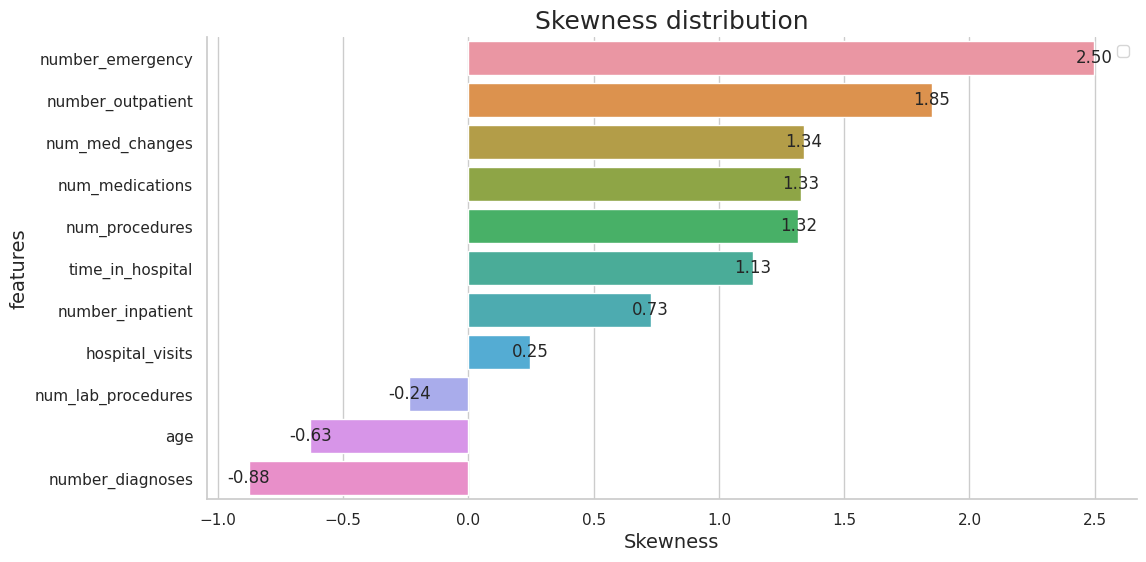

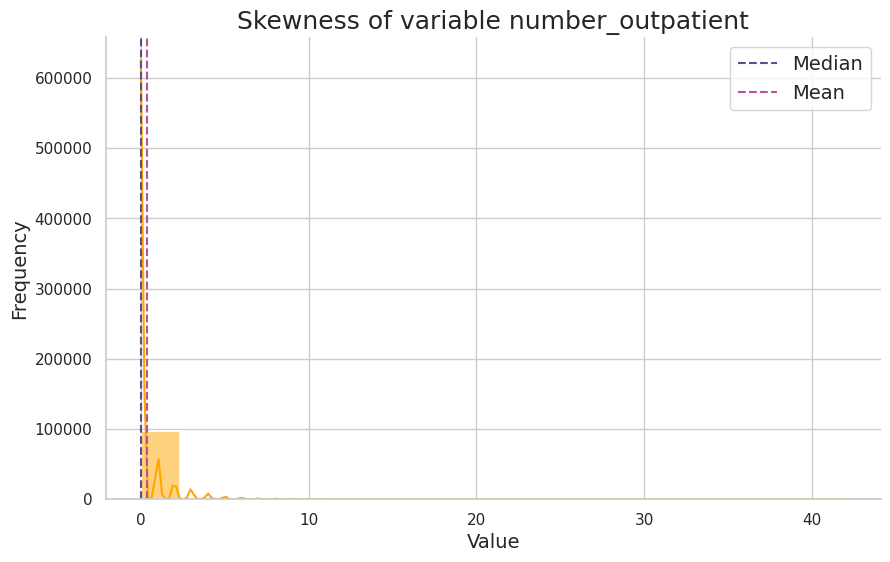

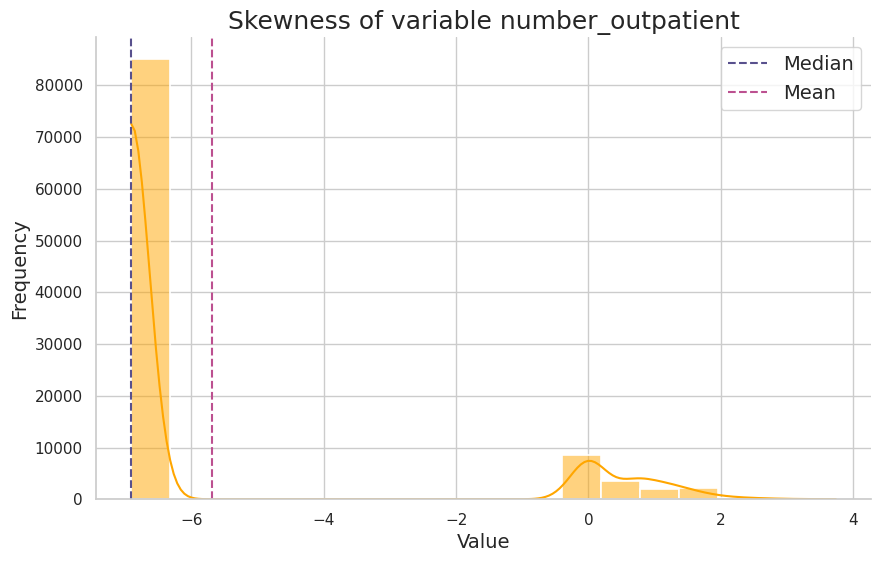

In [42]:
data = raw_data.copy(deep=True)

remove_skewness_kurtosis(data,numerical_features )

visualize_data_kurtosis(data,numerical_features)
visualize_data_skewness(data,numerical_features)

visualize_column_skewness(raw_data,'number_outpatient')
visualize_column_skewness(data,'number_outpatient')

1.5585264233634024
1.0


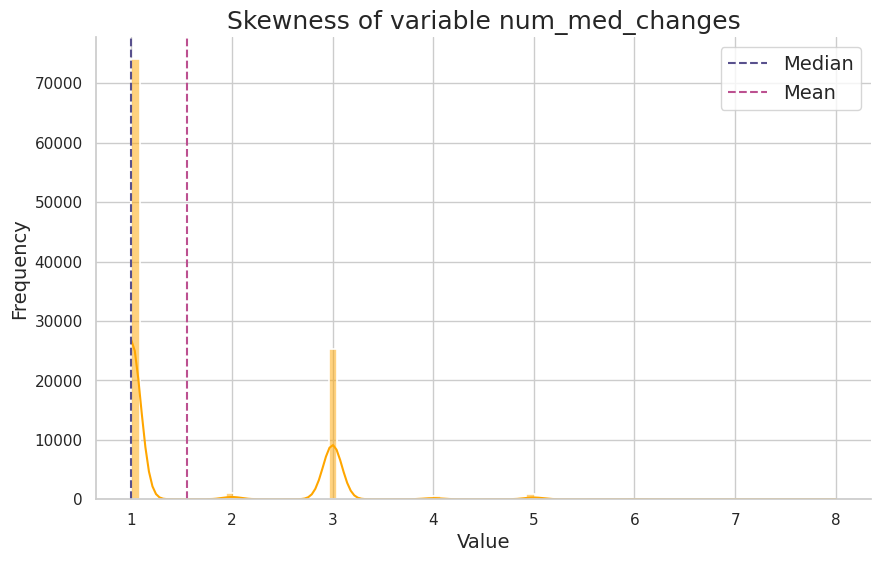

In [43]:
print(raw_data['num_med_changes'].mean())
print(raw_data['num_med_changes'].median())

visualize_column_skewness(raw_data,'num_med_changes')

# Modeling

In [44]:

from imblearn.over_sampling import SMOTE

non_numerical_features.append('readmitted')
cols = non_numerical_features

X = data.drop(cols,axis = 1)
y = data['readmitted']

# identify the minority class in the columns
minority_class = data['readmitted'].value_counts().index[-1]

sm = SMOTE(random_state=20)
X_trains, X_test, y_trains, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

X_train, y_train = sm.fit_resample(X_trains, y_trains)

#split the data into training and testing sets


### Logistic Regression

In [45]:
# create a logistic regression model
logreg = LogisticRegression()

# fit the model to the training data
logreg.fit(X_train, y_train)

# make predictions on the testing data
y_pred = logreg.predict(X_test)

# calculate the accuracy score
l_accuracy = accuracy_score(y_test, y_pred)

# calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:\n', cm)


Confusion Matrix:
 [[17606  9567]
 [ 2078  1279]]


### Decision Tree

In [46]:
clf = DecisionTreeClassifier(max_depth=28, criterion = "entropy", min_samples_split=10)
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model's accuracy
d_accuracy = clf.score(X_test, y_test)


### Randomn Forrest

In [47]:

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 25, 50],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy']
}


# Create a random forest classifier
rf = RandomForestClassifier(criterion='gini')

# Create the GridSearchCV object
grid_search = GridSearchCV(rf, param_grid, cv=5)

# Fit the GridSearchCV object to the training data
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_ 

# Create a new random forest classifier with the best hyperparameters
rf_best = RandomForestClassifier(**best_params)

# Train the classifier on the training data
rf_best.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_best.predict(X_test)

r_accuracy = rf_best.score(X_test, y_test)


### XGboost

In [ ]:
xb = XGBClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
xb.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xb.predict(X_test)

# Evaluate the model's accuracy
x_accuracy = xb.score(X_test, y_test)


# results

Logistic regression accuracy :  0.6185718964952506
Decision Tree accuracy :  0.8181788404847691
Randomn forrest accuracy :  0.8872911889944317
XGBoost accuracy :  0.8901408450704226


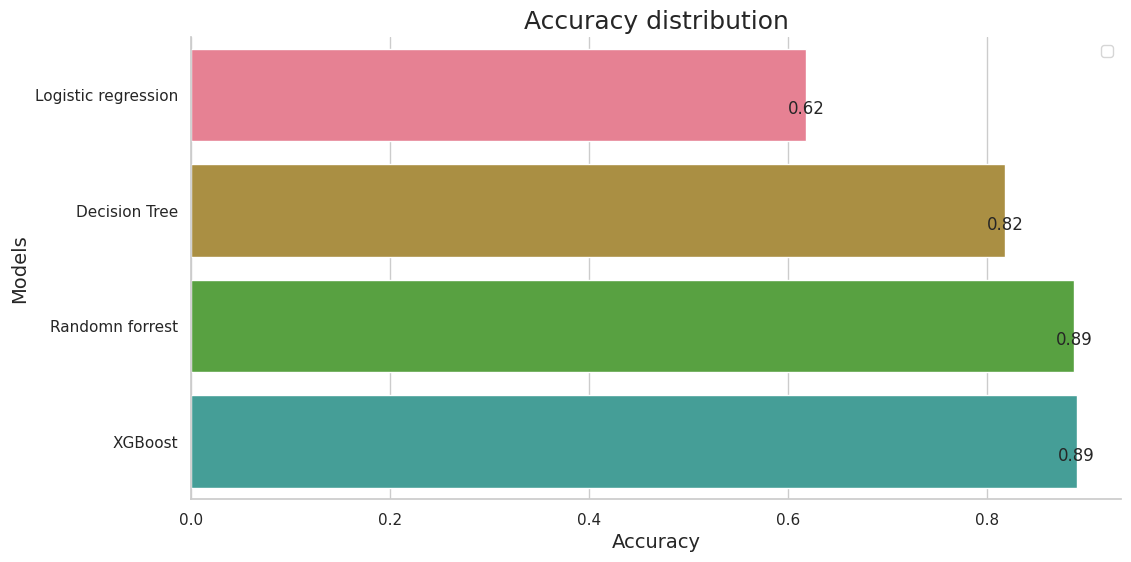

done niggaaaaa


In [ ]:
print( 'Logistic regression accuracy : ', l_accuracy)
print( 'Decision Tree accuracy : ', d_accuracy)
print( 'Randomn forrest accuracy : ', r_accuracy)
print( 'XGBoost accuracy : ', x_accuracy)

models = ['Logistic regression','Decision Tree', 'Randomn forrest','XGBoost']
accuracies = [l_accuracy,d_accuracy,r_accuracy,x_accuracy]
results = pd.DataFrame({'Models':models,'Accuracy': accuracies})

bar_plot(results,'Accuracy','Models')
print('done niggaaaaa')